In [1]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [2]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """

    def __init__(self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self, input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        # Сначала вычисляем градиент по входу
        grad_input = self.updateGradInput(input, gradOutput)
        # Затем вычисляем и накапливаем градиенты по параметрам
        self.accGradParameters(input, gradOutput)
        # Возвращаем градиент по входу
        return grad_input

    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [3]:
class Sequential(Module):
    """
    This class implements a container, which processes `input` data sequentially.

    `input` is processed by each module (layer) in self.modules consecutively.
    The resulting array is called `output`.
    """

    def __init__(self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """
        current_output = input
        if not self.modules:
            self.output = current_output
            return self.output
        for module in self.modules:
            current_output = module.forward(current_output)
        self.output = current_output
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        current_grad = gradOutput
        if not self.modules:
            self.gradInput = current_grad
            return self.gradInput
        for i in range(len(self.modules) - 1, -1, -1):
            module = self.modules[i]
            input_for_backward = input if i == 0 else self.modules[i - 1].output
            current_grad = module.backward(input_for_backward, current_grad)
        self.gradInput = current_grad
        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        params = []
        for module in self.modules:
            module_params = module.getParameters()
            # Важно: getParameters() может вернуть []
            if module_params:  # Проверяем, что список не пустой
                params.extend(module_params)
        return params

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        grad_params = []
        for module in self.modules:
            module_grad_params = module.getGradParameters()
            if module_grad_params:  # Проверяем, что список не пустой
                grad_params.extend(module_grad_params)
        return grad_params

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [4]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """

    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1.0 / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW += gradOutput.T @ input
        self.gradb += np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = "Linear %d -> %d" % (s[1], s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [5]:
class SoftMax(Module):
    def __init__(self):
        super(SoftMax, self).__init__()

    def updateOutput(self, input):
        stable_input = np.subtract(input, input.max(axis=1, keepdims=True))
        exp_output = np.exp(stable_input)
        sum_exp = np.sum(exp_output, axis=1, keepdims=True)
        # Добавим маленький эпсилон к знаменателю для дополнительной стабильности
        self.output = exp_output / (sum_exp + 1e-15)
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.output is None:
            raise ValueError("Output is not computed. Run forward pass first.")
        dot_product = np.sum(gradOutput * self.output, axis=1, keepdims=True)
        self.gradInput = self.output * (gradOutput - dot_product)
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [6]:
class LogSoftMax(Module):
    """LogSoftMax activation function."""

    def __init__(self):
        super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        stable_input = np.subtract(input, input.max(axis=1, keepdims=True))
        exp_stable = np.exp(stable_input)
        sum_exp_stable = np.sum(exp_stable, axis=1, keepdims=True)
        # Добавим эпсилон перед логарифмом
        log_sum_exp = np.log(sum_exp_stable + 1e-15)
        self.output = stable_input - log_sum_exp
        return self.output

    def updateGradInput(self, input, gradOutput):
        softmax_output = np.exp(self.output)
        sum_gradOutput = np.sum(gradOutput, axis=1, keepdims=True)
        self.gradInput = gradOutput - softmax_output * sum_gradOutput
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [7]:
class BatchNormalization(Module):

    EPS = 1e-5

    def __init__(self, alpha=0.9):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None
        # Статистики и промежуточные значения текущего батча (только для train)
        self.batch_mean = None
        self.batch_variance = None
        self.input_normalized = None
        self.inv_std = None
        self.input_shape = None

    def updateOutput(self, input):
        input_dtype = input.dtype
        input = input.astype(np.float64)  # Работаем с float64
        self.input_shape = input.shape
        if len(input.shape) != 2:
            raise ValueError(
                f"BatchNormalization expects 2D input (batch, features), got {input.shape}"
            )
        N, n_features = self.input_shape

        if self.training:
            if N == 1:
                # BN с батчем 1 в режиме train не имеет смысла, но PyTorch его обрабатывает,
                # используя moving average. Для простоты вернем 0 или вход.
                # Или можно использовать moving stats, если они есть
                print(
                    "Warning: BatchNormalization received batch size 1 in training mode."
                )
                if self.moving_mean is not None and self.moving_variance is not None:
                    # Используем moving stats как в eval режиме
                    inv_std_eval = 1.0 / np.sqrt(self.moving_variance + self.EPS)
                    self.output = (input - self.moving_mean) * inv_std_eval
                    # Не сохраняем batch stats и не обновляем moving stats
                    self.batch_mean = None
                    self.batch_variance = None
                    self.inv_std = None
                    self.input_normalized = None
                    return self.output.astype(input_dtype)
                else:  # Если и moving stats нет - возвращаем нули или вход
                    self.output = np.zeros_like(input)  # или input
                    return self.output.astype(input_dtype)

            # Стандартный расчет для N > 1
            self.batch_mean = np.mean(input, axis=0, keepdims=True)
            # Используем ddof=0 для biased variance
            self.batch_variance = np.var(input, axis=0, ddof=0, keepdims=True)

            if self.moving_mean is None:
                # ПЕРВЫЙ forward: Просто инициализируем статистики батча
                # (unbiased variance для moving_variance)
                self.moving_mean = self.batch_mean.copy()
                # PyTorch использует unbiased оценку для running_var
                unbiased_batch_variance = self.batch_variance * (
                    N / max(1.0, N - 1.0)
                )  # Деление на N-1, защита от N=1
                self.moving_variance = unbiased_batch_variance.copy()
            else:
                # ПОСЛЕДУЮЩИЕ forward: Обновляем по формуле
                self.moving_mean = (
                    self.alpha * self.moving_mean + (1.0 - self.alpha) * self.batch_mean
                )
                unbiased_batch_variance = self.batch_variance * (N / max(1.0, N - 1.0))
                self.moving_variance = (
                    self.alpha * self.moving_variance
                    + (1.0 - self.alpha) * unbiased_batch_variance
                )

            # Нормализация и сохранение для backward (используем biased variance батча)
            self.inv_std = 1.0 / np.sqrt(self.batch_variance + self.EPS)
            self.input_normalized = (input - self.batch_mean) * self.inv_std
            self.output = self.input_normalized

        else:  # Режим оценки
            if self.moving_mean is None or self.moving_variance is None:
                # Если не тренировали, инициализируем стандартно
                print(
                    "Warning: BN in eval mode without training. Using default stats (mean=0, var=1)."
                )
                self.moving_mean = np.zeros((1, n_features))
                self.moving_variance = np.ones((1, n_features))

            inv_std_eval = 1.0 / np.sqrt(self.moving_variance + self.EPS)
            self.output = (input - self.moving_mean) * inv_std_eval
            # Не сохраняем batch stats в eval
            self.batch_mean = None
            self.batch_variance = None
            self.inv_std = None
            self.input_normalized = None

        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        input_dtype = input.dtype
        gradOutput = gradOutput.astype(np.float64)
        input = input.astype(np.float64)  # Input нужен для backward в train

        if not self.training:
            # Backward в eval - используем moving stats
            if self.moving_variance is None:
                # Если нет moving stats, градиент не определен корректно
                print(
                    "Warning: BN backward called in eval mode without stats. Returning zero grad."
                )
                self.gradInput = np.zeros_like(input)
                return self.gradInput.astype(input_dtype)

            inv_std_eval = 1.0 / np.sqrt(self.moving_variance + self.EPS)
            self.gradInput = gradOutput * inv_std_eval
            return self.gradInput.astype(input_dtype)

        # Только для режима обучения (использует сохраненные batch stats)
        if (
            self.input_shape is None
            or self.batch_mean is None
            or self.input_normalized is None
            or self.inv_std is None
        ):
            raise RuntimeError(
                "Backward pass called in train mode without prior training forward pass or with batch_size=1."
            )

        N = self.input_shape[0]
        if N == 1:  # Градиент не определен для N=1 в train
            print(
                "Warning: BN backward called in train mode with batch_size=1. Returning zero grad."
            )
            self.gradInput = np.zeros_like(input)
            return self.gradInput.astype(input_dtype)

        gradOutput_sum = np.sum(gradOutput, axis=0, keepdims=True)
        gradOutput_x_output_sum = np.sum(
            gradOutput * self.input_normalized, axis=0, keepdims=True
        )

        self.gradInput = (
            (1.0 / N)
            * self.inv_std
            * (
                N * gradOutput
                - gradOutput_sum
                - self.input_normalized * gradOutput_x_output_sum
            )
        )
        return self.gradInput.astype(input_dtype)

    def __repr__(self):
        n_feats = (
            self.moving_mean.shape[1] if self.moving_mean is not None else "Unknown"
        )
        return "BatchNormalization"

In [8]:
class ChannelwiseScaling(Module):
    """
    Implements linear transform of input y = gamma * x + beta
    where gamma, beta - learnable vectors of length x.shape[-1]
    """

    def __init__(self, n_features):
        super(ChannelwiseScaling, self).__init__()
        self.gamma = np.ones(n_features)  # Веса (масштаб)
        self.beta = np.zeros(n_features)  # Смещения (сдвиг)
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)
        self.current_input = None  # Кэшируем вход для backward

    def updateOutput(self, input):
        if input.shape[-1] != self.gamma.shape[0]:
            raise ValueError(
                f"Input feature size {input.shape[-1]} != layer feature size {self.gamma.shape[0]}"
            )
        self.current_input = input
        # Broadcasting: (N, F) * (F,) + (F,) -> (N, F) или (N, C, H, W) * (C,) ...
        # Нужно, чтобы gamma/beta применялись к оси каналов/фичей (обычно ось 1 для Conv, ось -1 для Linear)
        # Сделаем универсальнее, предполагая, что последняя ось - фичи
        if input.ndim == 2:  # После Linear/Flatten
            self.output = self.gamma * input + self.beta
        elif input.ndim == 4:  # После Conv
            # gamma/beta shape (C,) -> reshape to (1, C, 1, 1) for broadcasting
            gamma_reshaped = self.gamma.reshape(1, -1, 1, 1)
            beta_reshaped = self.beta.reshape(1, -1, 1, 1)
            self.output = gamma_reshaped * input + beta_reshaped
        else:
            raise NotImplementedError("ChannelwiseScaling only supports 2D or 4D input")

        return self.output

    def updateGradInput(self, input, gradOutput):
        # dL/dInput = dL/dOutput * gamma
        if input.ndim == 2:
            self.gradInput = gradOutput * self.gamma
        elif input.ndim == 4:
            gamma_reshaped = self.gamma.reshape(1, -1, 1, 1)
            self.gradInput = gradOutput * gamma_reshaped
        else:  # Должно совпадать с updateOutput
            raise NotImplementedError(
                "ChannelwiseScaling only supports 2D or 4D input for backward"
            )
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        if self.current_input is None:
            raise RuntimeError("Need to run forward pass before accGradParameters.")
        # dL/dGamma = sum(dL/dOutput * input) по не-фичевым осям
        # dL/dBeta = sum(dL/dOutput) по не фичевым осям
        if self.current_input.ndim == 2:
            axis_to_sum = (0,)
        elif self.current_input.ndim == 4:
            axis_to_sum = (0, 2, 3)
        else:  # Должно совпадать с updateOutput
            raise NotImplementedError(
                "ChannelwiseScaling only supports 2D or 4D input for accGrad"
            )

        self.gradGamma += np.sum(gradOutput * self.current_input, axis=axis_to_sum)
        self.gradBeta += np.sum(gradOutput, axis=axis_to_sum)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [9]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p  # Вероятность зануления
        self.mask = None

    def updateOutput(self, input):
        if self.training:
            # Вероятность СОХРАНЕНИЯ элемента = 1 - p
            self.mask = np.random.binomial(
                n=1, p=(1.0 - self.p), size=input.shape
            ).astype(input.dtype)
            # Масштабирование (inverted dropout)
            scale_factor = (
                1.0 / (1.0 - self.p) if self.p < 1.0 else 0.0
            )  # Деление на ноль если p=1
            self.output = input * self.mask * scale_factor
        else:
            self.output = input
            self.mask = None  # Не нужна в режиме eval
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.training:
            if self.mask is None:
                raise RuntimeError(
                    "Dropout mask is not available. Run forward pass in training mode first."
                )
            scale_factor = 1.0 / (1.0 - self.p) if self.p < 1.0 else 0.0
            self.gradInput = gradOutput * self.mask * scale_factor
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

# 6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [10]:
def _pair(x, name="parameter"):
    """
    Эта функция позволяет пользователю передать одно число (например, kernel_size=3),
    и оно будет автоматически преобразовано в симметричную пару ((3, 3)).
    Если пользователь передает пару (kernel_size=(3, 5)), она используется как есть.
    Она также выполняет проверку типа и размера, выбрасывая ошибку, если входные данные некорректны.
    """
    if isinstance(x, int):
        return (x, x)
    if isinstance(x, tuple) and len(x) == 2 and all(isinstance(i, int) for i in x):
        return x
    raise ValueError(f"{name} must be int or tuple of 2 ints, but got {x}")


def _calculate_same_padding(input_size, kernel_size, stride):
    """
    Режим "same" padding в свертках стремится сделать так, чтобы размер выходной карты признаков был
    таким же (или почти таким же, с учетом шага stride), как и размер входной.
    Эта функция инкапсулирует формулу для расчета необходимого общего паддинга и его распределения (почти поровну) до и после оси.
    Используется внутри _resolve_padding в Conv2d
    """
    output_size = (input_size + stride - 1) // stride
    total_padding = max(0, (output_size - 1) * stride + kernel_size - input_size)
    pad_before = total_padding // 2
    pad_after = total_padding - pad_before
    return pad_before, pad_after


def get_im2col_indices(
    x_shape, kernel_h, kernel_w, stride_h, stride_w, pad_h_total, pad_w_total
):
    """
    Это ядро ​​техники im2col.
    Вместо того чтобы выполнять свертку с помощью скользящего окна и вложенных циклов, im2col преобразует задачу в одно большое матричное умножение.
    Эта функция генерирует индексы k (канал), i (строка) и j (столбец) для каждого элемента в каждом патче, которые соответствуют их положению в дополненном входном тензоре.
    Она также вычисляет размеры выходной карты (out_height, out_width). Эти индексы затем используются в im2col_indices и col2im_indices.
    """
    N, C, H, W = x_shape
    out_height = (H + pad_h_total - kernel_h) // stride_h + 1
    out_width = (W + pad_w_total - kernel_w) // stride_w + 1
    if out_height <= 0 or out_width <= 0:
        raise ValueError(f"Output size non-positive H={out_height}, W={out_width}")
    i0 = np.tile(np.repeat(np.arange(kernel_h), kernel_w), C)
    j0 = np.tile(np.tile(np.arange(kernel_w), kernel_h), C)
    i1 = stride_h * np.repeat(np.arange(out_height), out_width)
    j1 = stride_w * np.tile(np.arange(out_width), out_height)
    i = i0[:, None] + i1[None, :]
    j = j0[:, None] + j1[None, :]
    k = np.repeat(np.arange(C), kernel_h * kernel_w)
    return k.astype(int), i.astype(int), j.astype(int), out_height, out_width


def im2col_indices(x, kernel_h, kernel_w, stride_h, stride_w, pad_tuple, padding_mode):
    """
    Это ключевая функция для прямого прохода (updateOutput) свертки.
    После получения матрицы cols операция свертки сводится к одному матричному умножению: W_flat @ cols, где W_flat — это матрица весов свертки, развернутая в 2D.
    Матричное умножение в NumPy выполняется очень эффективно. Эта функция также возвращает информацию о форме выходного тензора.
    """
    N, C, H, W = x.shape
    pad_top, pad_bottom, pad_left, pad_right = pad_tuple
    pad_h_total = pad_top + pad_bottom
    pad_w_total = pad_left + pad_right
    if pad_h_total > 0 or pad_w_total > 0:
        np_pad_width = ((0, 0), (0, 0), (pad_top, pad_bottom), (pad_left, pad_right))
        mode_map = {"zeros": "constant", "reflect": "reflect", "replicate": "edge"}
        if padding_mode not in mode_map:
            raise ValueError(f"Unsupported padding: {padding_mode}")
        x_padded = np.pad(
            x,
            np_pad_width,
            mode=mode_map[padding_mode],
            **({"constant_values": 0} if padding_mode == "zeros" else {}),
        )
    else:
        x_padded = x
    k, i_rel_padded, j_rel_padded, H_out, W_out = get_im2col_indices(
        x.shape, kernel_h, kernel_w, stride_h, stride_w, pad_h_total, pad_w_total
    )
    cols = x_padded[:, k[:, None], i_rel_padded, j_rel_padded]
    cols = cols.transpose(1, 0, 2).reshape(C * kernel_h * kernel_w, N * H_out * W_out)
    output_shape_info = (N, -1, H_out, W_out)
    return cols, output_shape_info


def col2im_indices(cols, x_shape, kernel_h, kernel_w, stride_h, stride_w, pad_tuple):
    """
    Эта функция критически важна для обратного прохода (updateGradInput), то есть для вычисления градиента ошибки по отношению ко входу сверточного слоя (gradInput).
    Операция, которую она выполняет, по сути является "транспонированной сверткой" (хотя и реализованной через col2im), необходимой для распространения градиента назад через слой.
    Она использует те же индексы, что и im2col_indices, чтобы поместить значения из cols обратно в соответствующие позиции (потенциально дополненного) тензора градиента, а затем удаляет паддинг.
    """
    N, C, H, W = x_shape
    pad_top, pad_bottom, pad_left, pad_right = pad_tuple
    pad_h_total = pad_top + pad_bottom
    pad_w_total = pad_left + pad_right
    H_padded = H + pad_h_total
    W_padded = W + pad_w_total
    k, i_rel_padded, j_rel_padded, H_out, W_out = get_im2col_indices(
        x_shape, kernel_h, kernel_w, stride_h, stride_w, pad_h_total, pad_w_total
    )
    x_padded_grad = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    cols_reshaped = cols.reshape(C * kernel_h * kernel_w, N, H_out * W_out).transpose(
        1, 0, 2
    )
    idx_n = np.arange(N)[:, None, None]
    np.add.at(
        x_padded_grad,
        (idx_n, k[None, :, None], i_rel_padded[None, :, :], j_rel_padded[None, :, :]),
        cols_reshaped,
    )
    if pad_h_total == 0 and pad_w_total == 0:
        return x_padded_grad
    else:
        return x_padded_grad[
            :, :, pad_top : H_padded - pad_bottom, pad_left : W_padded - pad_right
        ]

In [11]:
class Conv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        bias=True,
        padding_mode="zeros",
    ):
        super(Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding_arg = padding
        self.use_bias = bias
        if padding_mode not in ["zeros", "reflect", "replicate"]:
            raise ValueError(f"Unsupported padding_mode: {padding_mode}")
        self.padding_mode = padding_mode
        fan_in = self.in_channels * self.kernel_size[0] * self.kernel_size[1]
        bound = np.sqrt(6.0 / fan_in) if fan_in > 0 else 0
        self.W = np.random.uniform(
            -bound,
            bound,
            (out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]),
        ).astype(np.float64)
        self.gradW = np.zeros_like(self.W)
        if self.use_bias:
            bound_b = 1.0 / np.sqrt(fan_in) if fan_in > 0 else 0
            self.b = np.random.uniform(-bound_b, bound_b, out_channels).astype(
                np.float64
            )
            self.gradB = np.zeros_like(self.b)
        else:
            self.b = None
            self.gradB = None
        self.input_shape = None
        self.cols = None
        self.calculated_padding_tuple = None
        self.output_shape_info = None
        self.weight = self.W
        self.bias = self.b

    def _resolve_padding(self, H_in, W_in):
        KH, KW = self.kernel_size
        SH, SW = self.stride
        if isinstance(self.padding_arg, str):
            pad_str = self.padding_arg.lower()
            pt, pb, pl, pr = 0, 0, 0, 0
            if pad_str == "valid":
                pass
            elif pad_str == "same":
                pt, pb = _calculate_same_padding(H_in, KH, SH)
                pl, pr = _calculate_same_padding(W_in, KW, SW)
            else:
                raise ValueError(f"Unknown padding string: {self.padding_arg}")
            return (pt, pb, pl, pr)
        else:
            PH, PW = _pair(self.padding_arg)
            return (PH, PH, PW, PW)

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)
        self.input_shape = input.shape
        N, C_in, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        self.calculated_padding_tuple = self._resolve_padding(H_in, W_in)
        self.cols, self.output_shape_info = im2col_indices(
            input_f64, KH, KW, SH, SW, self.calculated_padding_tuple, self.padding_mode
        )
        W_flat = self.W.reshape(self.out_channels, -1)
        result = W_flat @ self.cols
        if self.use_bias:
            result += self.b.reshape(-1, 1)
        N_out, _, H_out, W_out = self.output_shape_info
        try:
            self.output = result.reshape(
                self.out_channels, N_out, H_out, W_out
            ).transpose(1, 0, 2, 3)
        except ValueError as e:
            raise ValueError(f"Output reshape error: {e}")
        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        input_dtype = input.dtype
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)
        N, C_out, H_out, W_out = gradOutput.shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        gradOutput_flat = gradOutput_f64.transpose(1, 0, 2, 3).reshape(
            self.out_channels, -1
        )
        W_flat = self.W.reshape(self.out_channels, -1)
        grad_cols = W_flat.T @ gradOutput_flat
        self.gradInput = col2im_indices(
            grad_cols, self.input_shape, KH, KW, SH, SW, self.calculated_padding_tuple
        )
        return self.gradInput.astype(input_dtype)

    def accGradParameters(self, input, gradOutput):
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)

        N, C_out, H_out, W_out = gradOutput.shape
        KH, KW = self.kernel_size
        if self.use_bias:  #
            self.gradB += np.sum(gradOutput_f64, axis=(0, 2, 3))
        gradOutput_flat = gradOutput_f64.transpose(1, 0, 2, 3).reshape(
            self.out_channels, -1
        )
        gradW_flat = gradOutput_flat @ self.cols.T
        self.gradW += gradW_flat.reshape(self.W.shape)

    def zeroGradParameters(self):
        if hasattr(self, "gradW") and self.gradW is not None:
            self.gradW.fill(0)
        if self.use_bias and hasattr(self, "gradB") and self.gradB is not None:
            self.gradB.fill(0)

    def getParameters(self):
        return [self.W, self.b] if self.use_bias else [self.W]

    def getGradParameters(self):
        return [self.gradW, self.gradB] if self.use_bias else [self.gradW]

    def __repr__(self):
        return "Conv2d"

#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [12]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MaxPool2d, self).__init__()

        self.kernel_size = _pair(kernel_size, "kernel_size")
        self.stride = _pair(stride if stride is not None else kernel_size, "stride")
        self.padding_arg = padding

        if any(s > k for s, k in zip(self.stride, self.kernel_size)):
            print(
                f"Warning: MaxPool2d stride {self.stride} > kernel_size {self.kernel_size}. This is unusual."
            )
        self.max_indices = None
        self.input_shape = None
        self.calculated_padding_tuple = None

    def _resolve_padding(self, H_in, W_in):
        # Вычисляет (top, bottom, left, right) паддинг для MaxPool
        try:
            PH, PW = _pair(self.padding_arg, "padding")
            return (PH, PH, PW, PW)
        except ValueError:
            raise ValueError(
                f"MaxPool2d padding must be int or tuple of 2 ints, got {self.padding_arg}"
            )

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)
        self.input_shape = input.shape
        N, C, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride

        self.calculated_padding_tuple = self._resolve_padding(H_in, W_in)
        pad_top, pad_bottom, pad_left, pad_right = self.calculated_padding_tuple
        pad_h_total = pad_top + pad_bottom
        pad_w_total = pad_left + pad_right

        H_out = (H_in + pad_h_total - KH) // SH + 1
        W_out = (W_in + pad_w_total - KW) // SW + 1

        current_padding_mode = "zeros"
        cols, _ = im2col_indices(
            input_f64,
            KH,
            KW,
            SH,
            SW,
            pad_tuple=self.calculated_padding_tuple,
            padding_mode=current_padding_mode,
        )

        cols_reshaped = cols.reshape(C, KH * KW, -1)
        max_vals = np.max(cols_reshaped, axis=1)
        self.max_indices = np.argmax(cols_reshaped, axis=1)

        try:
            self.output = max_vals.reshape(C, N, H_out, W_out).transpose(1, 0, 2, 3)
        except ValueError as e:
            raise ValueError(f"MaxPool2d reshape error: {e}")

        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        input_dtype = input.dtype
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)

        N, C, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride

        _, _, H_out, W_out = gradOutput.shape

        grad_cols_shape = (C * KH * KW, N * H_out * W_out)
        grad_cols = np.zeros(grad_cols_shape, dtype=gradOutput_f64.dtype)
        gradOutput_flat = gradOutput_f64.transpose(1, 0, 2, 3).reshape(C, -1)

        channel_offsets = np.arange(C)[:, None] * (KH * KW)
        row_indices = channel_offsets + self.max_indices

        col_indices = np.arange(N * H_out * W_out)[None, :]

        flat_row_indices = row_indices.ravel()
        flat_col_indices = np.tile(col_indices, (C, 1)).ravel()
        flat_gradOutput = gradOutput_flat.ravel()

        np.add.at(grad_cols, (flat_row_indices, flat_col_indices), flat_gradOutput)

        self.gradInput = col2im_indices(
            grad_cols,
            self.input_shape,
            KH,
            KW,
            SH,
            SW,
            self.calculated_padding_tuple,
        )

        return self.gradInput.astype(input_dtype)

    def __repr__(self):
        return "MaxPool2d"


class AvgPool2d(Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(AvgPool2d, self).__init__()

        self.kernel_size = _pair(kernel_size, "kernel_size")
        self.stride = _pair(stride if stride is not None else kernel_size, "stride")
        self.padding_arg = padding
        self.pool_size = self.kernel_size[0] * self.kernel_size[1]
        if self.pool_size == 0:
            raise ValueError("Pool size cannot be zero")
        self.input_shape = None
        self.calculated_padding_tuple = None

    def _resolve_padding(self, H_in, W_in):
        """Вычисляет (top, bottom, left, right) паддинг для AvgPool."""
        try:
            PH, PW = _pair(self.padding_arg, "padding")
            return (PH, PH, PW, PW)  # Симметричный паддинг
        except ValueError:
            raise ValueError(
                f"AvgPool2d padding must be int or tuple of 2 ints, got {self.padding_arg}"
            )

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)
        self.input_shape = input.shape
        N, C, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        self.calculated_padding_tuple = self._resolve_padding(H_in, W_in)
        pad_top, pad_bottom, pad_left, pad_right = self.calculated_padding_tuple
        pad_h_total = pad_top + pad_bottom
        pad_w_total = pad_left + pad_right

        H_out = (H_in + pad_h_total - KH) // SH + 1
        W_out = (W_in + pad_w_total - KW) // SW + 1

        current_padding_mode = "zeros"
        cols, _ = im2col_indices(
            input_f64,
            KH,
            KW,
            SH,
            SW,
            pad_tuple=self.calculated_padding_tuple,
            padding_mode=current_padding_mode,
        )

        cols_reshaped = cols.reshape(C, KH * KW, -1)
        avg_vals = np.mean(cols_reshaped, axis=1)

        try:
            self.output = avg_vals.reshape(C, N, H_out, W_out).transpose(1, 0, 2, 3)
        except ValueError as e:
            raise ValueError(f"AvgPool2d reshape error: {e}")

        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        input_dtype = input.dtype
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)

        N, C, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        _, _, H_out, W_out = gradOutput.shape

        gradOutput_flat = gradOutput_f64.transpose(1, 0, 2, 3).reshape(C, -1)
        gradOutput_divided = gradOutput_flat / self.pool_size

        grad_cols_per_channel = np.repeat(
            gradOutput_divided[:, np.newaxis, :], KH * KW, axis=1
        )
        grad_cols = grad_cols_per_channel.reshape(C * KH * KW, -1)

        self.gradInput = col2im_indices(
            grad_cols,
            self.input_shape,
            KH,
            KW,
            SH,
            SW,
            self.calculated_padding_tuple,
        )
        return self.gradInput.astype(input_dtype)

    def __repr__(self):
        return "AvgPool2d"

# 8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [13]:
class GlobalMaxPool2d(Module):

    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()
        self.input_shape = None
        self.max_indices_flat = None

    def updateOutput(self, input):
        self.input_shape = input.shape
        N, C, H, W = self.input_shape
        self.output = np.max(input, axis=(2, 3), keepdims=True)
        input_reshaped = input.reshape(N, C, H * W)
        self.max_indices_flat = np.argmax(input_reshaped, axis=2)
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H, W = self.input_shape
        self.gradInput = np.zeros(self.input_shape, dtype=gradOutput.dtype)
        gradOutput_flat = gradOutput.reshape(N, C)
        idx_n, idx_c = np.meshgrid(np.arange(N), np.arange(C), indexing="ij")
        idx_h, idx_w = np.unravel_index(self.max_indices_flat, (H, W))
        self.gradInput[idx_n, idx_c, idx_h, idx_w] = gradOutput_flat
        return self.gradInput


class GlobalAvgPool2d(Module):

    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
        self.input_shape = None

    def updateOutput(self, input):
        self.input_shape = input.shape
        N, C, H, W = self.input_shape
        self.output = np.mean(input, axis=(2, 3), keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H, W = self.input_shape
        pool_size = float(H * W)
        self.gradInput = gradOutput / pool_size
        if self.gradInput.shape != self.input_shape:
            self.gradInput = np.broadcast_to(self.gradInput, self.input_shape)
        return self.gradInput

# 9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [14]:
class Flatten(Module):
    def __init__(self, start_dim=1, end_dim=-1):
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim
        self.original_shape = None

    def updateOutput(self, input):
        self.original_shape = input.shape
        n_dims = input.ndim

        actual_start_dim = (
            self.start_dim if self.start_dim >= 0 else n_dims + self.start_dim
        )
        actual_end_dim = self.end_dim if self.end_dim >= 0 else n_dims + self.end_dim

        new_shape = []
        new_shape.extend(self.original_shape[:actual_start_dim])
        new_shape.append(-1)
        new_shape.extend(self.original_shape[actual_end_dim + 1 :])

        self.output = input.reshape(tuple(new_shape))
        return self.output

    def updateGradInput(self, input, gradOutput):
        try:
            self.gradInput = gradOutput.reshape(self.original_shape)
        except ValueError as e:
            raise ValueError(
                f"Cannot reshape gradOutput shape {gradOutput.shape} "
                f"back to original input shape {self.original_shape}. Mismatched elements? Error: {e}"
            )

        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [15]:
class ReLU(Module):

    def __init__(self):
        super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput, input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU()"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [16]:
class LeakyReLU(Module):

    def __init__(self, slope=0.01):
        super(LeakyReLU, self).__init__()
        self.slope = slope

    def updateOutput(self, input):
        self.output = np.where(input >= 0, input, self.slope * input)
        return self.output

    def updateGradInput(self, input, gradOutput):
        grad_mask = np.where(input >= 0, 1.0, self.slope)
        self.gradInput = gradOutput * grad_mask
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [17]:
class ELU(Module):

    def __init__(self, alpha=1.0):
        super(ELU, self).__init__()
        self.alpha = alpha

    def updateOutput(self, input):
        self.output = np.where(input >= 0, input, self.alpha * (np.exp(input) - 1.0))
        return self.output

    def updateGradInput(self, input, gradOutput):
        grad_mask = np.where(input >= 0, 1.0, self.alpha * np.exp(input))
        self.gradInput = gradOutput * grad_mask
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [18]:
class SoftPlus(Module):

    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Стабильная версия log(1 + exp(x))
        self.output = np.logaddexp(0, input)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Производная = sigmoid(x)
        sigmoid_input = 1.0 / (1.0 + np.exp(-input))
        self.gradInput = gradOutput * sigmoid_input
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [19]:
class Gelu(Module):

    def __init__(self):
        super(Gelu, self).__init__()
        self.sqrt_2_div_pi = np.sqrt(2.0 / np.pi)
        self.coeff = 0.044715

    def _gelu_approx(self, x):
        inner = self.sqrt_2_div_pi * (x + self.coeff * np.power(x, 3))
        return 0.5 * x * (1.0 + np.tanh(inner))

    def _gelu_approx_derivative(self, x):
        inner = self.sqrt_2_div_pi * (x + self.coeff * np.power(x, 3))
        tanh_inner = np.tanh(inner)
        inner_derivative = self.sqrt_2_div_pi * (
            1.0 + 3.0 * self.coeff * np.power(x, 2)
        )
        tanh_derivative = (1.0 - np.power(tanh_inner, 2)) * inner_derivative
        derivative = 0.5 * (1.0 + tanh_inner) + 0.5 * x * tanh_derivative
        return derivative

    def updateOutput(self, input):
        input_f64 = input.astype(np.float64)
        self.output = self._gelu_approx(input_f64)
        return self.output.astype(input.dtype)

    def updateGradInput(self, input, gradOutput):
        input_f64 = input.astype(np.float64)
        gelu_derivative = self._gelu_approx_derivative(input_f64)
        self.gradInput = gradOutput * gelu_derivative.astype(gradOutput.dtype)
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [20]:
class Criterion(object):

    def __init__(self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
        Given an input and a target, compute the loss function
        associated to the criterion and return the result.

        For consistency this function should not be overrided,
        all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
        Given an input and a target, compute the gradients of the loss function
        associated to the criterion and return the result.

        For consistency this function should not be overrided,
        all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        raise NotImplementedError

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        raise NotImplementedError

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [21]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        sum_sq_diff = np.sum(np.power(input - target, 2))
        self.output = sum_sq_diff / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = (input - target) * 2.0 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [22]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15

    def __init__(self):
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1.0 - self.EPS)
        log_probs = np.log(input_clamp)
        sum_log_probs_true_class = np.sum(target * log_probs)
        batch_size = input.shape[0]
        self.output = -sum_log_probs_true_class / batch_size
        return self.output

    def updateGradInput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1.0 - self.EPS)
        batch_size = input.shape[0]
        self.gradInput = -(target / input_clamp) / batch_size
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [23]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        log_probs_true_class = np.sum(target * input, axis=1)
        batch_size = input.shape[0]
        self.output = -np.sum(log_probs_true_class) / batch_size
        return self.output

    def updateGradInput(self, input, target):
        batch_size = input.shape[0]
        self.gradInput = -target / batch_size
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

In [24]:
import torch.nn.functional as F
import math
import pickle
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, f1_score

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# №1 Оптимизаторы SGD и Adam

In [25]:
class SGD:
    def __init__(self, model_parameters, learning_rate=1e-3, weight_decay=0):
        self.parameters = model_parameters
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def step(self, model_grads):
        for i in range(len(self.parameters)):
            param = self.parameters[i]
            grad = model_grads[i]

            if param is None or grad is None:
                continue  # Пропуск, если нет параметра/градиента

            # L2 регуляризация (weight decay) - добавляем к градиенту
            if (
                self.weight_decay > 0 and param.ndim > 1
            ):  # Обычно не применяют к смещениям (bias)
                grad = grad + self.weight_decay * param

            if param.dtype != grad.dtype:  # Согласование типов (на всякий случай)
                param -= self.learning_rate * grad.astype(param.dtype)
            else:
                param -= self.learning_rate * grad

    def zero_grad(self, model):
        model.zeroGradParameters()


class Adam:
    def __init__(
        self,
        model_parameters,
        learning_rate=1e-3,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8,
        weight_decay=0,
    ):
        self.parameters = model_parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.m = [
            np.zeros_like(p, dtype=np.float64) if p is not None else None
            for p in model_parameters
        ]  # 1st moment vector
        self.v = [
            np.zeros_like(p, dtype=np.float64) if p is not None else None
            for p in model_parameters
        ]  # 2nd moment vector
        self.t = 0  # Timestep

    def step(self, model_grads):
        if len(self.parameters) != len(model_grads):
            raise ValueError(
                f"Params ({len(self.parameters)}) and grads ({len(model_grads)}) count mismatch."
            )
        self.t += 1

        for i in range(len(self.parameters)):
            param = self.parameters[i]
            grad = model_grads[i]

            if param is None or grad is None:
                continue

            grad = grad.astype(np.float64, copy=False)

            # L2 регуляризация
            if self.weight_decay > 0 and param.ndim > 1:
                grad = grad + self.weight_decay * param

            # Обновление моментов
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad**2)

            # Коррекция смещения моментов
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            # Обновление параметра
            update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            if param.dtype != update.dtype:
                param -= update.astype(param.dtype)
            else:
                param -= update

    def zero_grad(self, model):
        model.zeroGradParameters()

# Доп функции активации и loss

In [26]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()
        self.output = None

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)
        self.output = 1.0 / (1.0 + np.exp(-input_f64))
        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        o64 = self.output
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)
        # Вычисляем градиент
        self.gradInput = gradOutput_f64 * o64 * (1.0 - o64)
        return self.gradInput.astype(input.dtype)


class Tanh(Module):
    def __init__(self):
        super(Tanh, self).__init__()
        self.output = None

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)
        # Кэшируем выход как float64 для backward
        self.output = np.tanh(input_f64)
        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        o64 = self.output
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)
        # Вычисляем градиент
        self.gradInput = gradOutput_f64 * (1.0 - o64**2)
        return self.gradInput.astype(input.dtype)


class MAECriterion(Criterion):
    def forward(self, y_pred, y_true):
        return np.mean(np.abs(y_pred - y_true))

    def backward(self, y_pred, y_true):
        return np.sign(y_pred - y_true) / y_true.shape[0]


class CrossEntropyCriterion(Criterion):

    def __init__(self):
        super().__init__()
        self._softmax_output = None

    def _softmax_stable(self, x):
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(x_shifted)
        return exps / np.sum(exps, axis=1, keepdims=True)

    def _logsoftmax_stable(self, x):
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        log_sum_exp = np.max(x, axis=1, keepdims=True) + np.log(
            np.sum(np.exp(x_shifted), axis=1, keepdims=True)
        )
        return x - log_sum_exp

    def updateOutput(self, input, target):
        batch_size = input.shape[0]
        log_softmax_output = self._logsoftmax_stable(input)
        self._softmax_output = np.exp(log_softmax_output)
        true_class_log_probs = log_softmax_output[np.arange(batch_size), target]
        loss = -np.mean(true_class_log_probs)

        self.output = loss
        return self.output

    def updateGradInput(self, input, target):
        batch_size = input.shape[0]
        num_classes = input.shape[1]
        one_hot_target = np.zeros_like(input)
        one_hot_target[np.arange(batch_size), target] = 1
        grad = (self._softmax_output - one_hot_target) / batch_size

        self.gradInput = grad
        return self.gradInput

In [27]:
class StagnationMonitor:
    """
    Отслеживает значение (например, функцию потерь или метрику) и
    определяет, прекратилось ли его улучшение в течение заданного
    числа шагов "patience".

    Учитывает пороговое значение "threshold" для определения значимости
    улучшения и режим "mode" для минимизации или максимизации.
    Может использоваться для реализации механизма ранней остановки
    в процессах оптимизации.

    patience: Максимальное количество шагов без улучшения.
    threshold: Минимальное изменение, считающееся улучшением.
    mode: 'min' (минимизация) или 'max' (максимизация).
    verbose: Выводить ли сообщения о состоянии.
    counter: Счетчик шагов без улучшения.
    best_value: Лучшее значение, достигнутое до сих пор.
    stagnated: Флаг, указывающий на обнаружение стагнации.
    """

    def __init__(self, patience=5, threshold=1e-4, mode="min", verbose=True):
        self.patience = patience
        self.threshold = threshold
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_value = np.inf if mode == "min" else -np.inf
        self.stagnated = False

    def __call__(self, value):
        improved = False
        if self.mode == "min":
            if value < self.best_value - self.threshold:
                improved = True
        else:  # mode == 'max'
            if value > self.best_value + self.threshold:
                improved = True

        if improved:
            self.best_value = value
            self.counter = 0
            self.stagnated = False
        else:
            self.counter += 1
            if self.verbose:
                print(
                    f"Stagnation Monitor: Нет улучшения для {self.counter}/{self.patience} epochs."
                )
            if self.counter >= self.patience:
                self.stagnated = True
                if self.verbose:
                    print("Stagnation Monitor: Стагнация обнаружена.")

    def reset(self):
        self.counter = 0
        self.best_value = np.inf if self.mode == "min" else -np.inf
        self.stagnated = False
        if self.verbose:
            print("Stagnation Monitor: Reset.")

# StepLR, Warmup, EarlyStopping 

In [28]:
class StepLR:
    def __init__(self, optimizer, step_size, gamma=0.1):
        self.optimizer = optimizer
        self.step_size = step_size
        self.gamma = gamma
        self.last_epoch = 0

    def step(self):
        self.last_epoch += 1
        if self.last_epoch % self.step_size == 0:
            self.optimizer.learning_rate *= self.gamma


class WarmupLR:
    def __init__(
        self,
        optimizer,
        warmup_epochs,
        initial_lr,
        target_lr,
        scheduler_after_warmup=None,
    ):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.scheduler_after_warmup = scheduler_after_warmup
        self.current_epoch = 0
        self.original_lr = optimizer.learning_rate  # Сохраняем исходный LR оптимизатора

        # Устанавливаем начальный LR для warmup
        self.optimizer.learning_rate = initial_lr

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Линейный warmup
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * (
                self.current_epoch / self.warmup_epochs
            )
            self.optimizer.learning_rate = lr
            if self.current_epoch == self.warmup_epochs:
                self.optimizer.learning_rate = self.original_lr
        elif self.scheduler_after_warmup:
            # После warmup передаем управление основному scheduler'у
            # Уменьшаем его счетчик, т.к. он пропустил warmup эпохи
            self.scheduler_after_warmup.last_epoch = (
                self.current_epoch - self.warmup_epochs
            )
            self.scheduler_after_warmup.step()


class EarlyStopping:
    def __init__(
        self,
        patience=5,
        verbose=False,
        delta=0,
        path="checkpoint.pkl",
        trace_func=print,
    ):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta  # Минимальное изменение, считающееся улучшением
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = (
            -val_loss
        )  # Мы минимизируем loss, поэтому лучший score - максимальный (-loss)
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(
                    f"  EarlyStopping counter: {self.counter} out of {self.patience}"
                )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(
                f"  Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ..."
            )
        parameters = model.getParameters()
        try:
            with open(self.path, "wb") as f:
                pickle.dump(parameters, f)
            self.val_loss_min = val_loss
        except Exception as e:
            self.trace_func(f"Error saving model: {e}")

    def load_best_model(self, model):
        if os.path.exists(self.path):
            print(
                f"Loading best model from {self.path} with val_loss: {self.val_loss_min:.6f}"
            )
            try:
                with open(self.path, "rb") as f:
                    best_params = pickle.load(f)
                current_params = model.getParameters()
                if len(best_params) == len(current_params):
                    for i in range(len(best_params)):
                        if current_params[i] is not None and best_params[i] is not None:
                            # Проверяем совпадение формы перед копированием
                            if current_params[i].shape == best_params[i].shape:
                                np.copyto(current_params[i], best_params[i])
                            else:
                                print(
                                    f"  Warning: Shape mismatch for param {i}. Expected {current_params[i].shape}, got {best_params[i].shape}. Skipping."
                                )
                        elif (
                            current_params[i] is not None or best_params[i] is not None
                        ):
                            # Ситуация, когда параметр есть/нет (например, bias изменился)
                            print(
                                f"  Warning: Parameter presence mismatch for param {i}. Skipping."
                            )
                else:
                    print(
                        "  Warning: Number of parameters in saved model differs from current model. Cannot load."
                    )
                return True
            except Exception as e:
                print(f"   Error loading model: {e}")
                return False
        else:
            print(f"   Best model checkpoint not found at {self.path}")
            return False

In [29]:
def calculate_accuracy(y_true_indices, y_pred_indices):
    return accuracy_score(y_true_indices, y_pred_indices)


def calculate_r2(y_pred, y_true):
    return r2_score(y_true, y_pred)


def calculate_f1(y_pred, y_true):
    return f1_score(y_true, y_pred, average="weighted")


def get_batches(X, y, batch_size):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]


def plot_history(
    train_loss,
    val_loss,
    train_metric=None,
    val_metric=None,
    metric_name="Metric",
    title_suffix="",
):
    plt.style.use("seaborn-v0_8-whitegrid")  # Стиль для графиков
    epochs_range = range(1, len(train_loss) + 1)
    n_plots = 1 + (1 if train_metric is not None and val_metric is not None else 0)
    fig, axs = plt.subplots(1, n_plots, figsize=(8 * n_plots, 5))
    if n_plots == 1:
        axs = [axs]  # Делаем массив для единообразия

    main_title = "Training History" + (f" - {title_suffix}" if title_suffix else "")
    fig.suptitle(main_title, fontsize=14)

    # График потерь
    axs[0].plot(
        epochs_range,
        train_loss,
        "o-",
        label="Train Loss",
        color="dodgerblue",
        markersize=4,
    )
    axs[0].plot(
        epochs_range,
        val_loss,
        "o-",
        label="Validation Loss",
        color="darkorange",
        markersize=4,
    )
    axs[0].set_title("Loss History")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    if train_metric is not None:

        axs[1].plot(
            epochs_range,
            train_metric,
            "o-",
            label=f"Train {metric_name}",
            color="dodgerblue",
            markersize=4,
        )
        axs[1].plot(
            epochs_range,
            val_metric,
            "o-",
            label=f"Validation {metric_name}",
            color="darkorange",
            markersize=4,
        )
        axs[1].set_title(f"{metric_name} History")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel(metric_name)
        axs[1].legend()
        axs[1].grid(True)
        axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Функция обучение и отрисовки графиков Loss и Метрики

In [30]:
def train_validate_model(
    model,
    initial_criterion,
    initial_optimizer,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs,
    batch_size,
    # --- Параметры для переключения Criterion ---
    loss_switch_trigger_config=None,
    next_criterion_instance=None,
    # --- Параметры для переключения Optimizer ---
    optimizer_switch_trigger_config=None,
    next_optimizer_class=None,
    next_optimizer_params=None,
    # --- Основные параметры ---
    scheduler=None,
    warmup_scheduler=None,
    early_stopping=None,
    metric_func=None,
    metric_name="Metric",
    task_type="classification",
    metric_for_switch="val_loss",
):
    train_loss_history = []
    val_loss_history = []
    train_metric_history = []
    val_metric_history = []

    current_criterion = initial_criterion
    current_optimizer = initial_optimizer
    current_lr = getattr(current_optimizer, "learning_rate", "N/A")

    loss_has_switched = False
    optimizer_has_switched = False

    loss_switch_monitor = None
    can_switch_loss = False
    if loss_switch_trigger_config and isinstance(next_criterion_instance, Criterion):
        loss_switch_monitor = StagnationMonitor(**loss_switch_trigger_config)
        can_switch_loss = True
        print(f"INFO: Loss switch monitoring enabled...")
    optimizer_switch_monitor = None
    can_switch_optimizer = False
    if (
        optimizer_switch_trigger_config
        and next_optimizer_class
        and next_optimizer_params
    ):
        is_class = isinstance(next_optimizer_class, type)
        if is_class:
            optimizer_switch_monitor = StagnationMonitor(
                **optimizer_switch_trigger_config
            )
            can_switch_optimizer = True
            print(f"INFO: Optimizer switch monitoring enabled...")
        else:
            print(f"WARN: 'next_optimizer_class' should be a class...")

    print(
        f"\nStarting training with Criterion: {current_criterion.__class__.__name__}, Optimizer: {current_optimizer.__class__.__name__}"
    )

    # Цикл обучения
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        metric_total = 0.0
        processed_samples = 0

        # Обновления LR
        lr_before_step = getattr(current_optimizer, "learning_rate", "N/A")
        if warmup_scheduler and epoch < warmup_scheduler.warmup_epochs:
            # Убедимся, что warmup работает с текущим оптимизатором
            warmup_scheduler.optimizer = current_optimizer
            warmup_scheduler.step()
        elif scheduler:
            # Убедимся, что scheduler работает с текущим оптимизатором
            scheduler.optimizer = current_optimizer
            scheduler.step()
        current_lr = getattr(current_optimizer, "learning_rate", lr_before_step)

        # Модуль тренировки
        train_batches = tqdm(
            get_batches(X_train, y_train, batch_size),
            total=math.ceil(X_train.shape[0] / batch_size),
            desc=f"Epoch {epoch+1}/{epochs} [Train]",
            leave=False,
        )
        for X_batch, y_batch in train_batches:
            current_optimizer.zero_grad(model)
            y_pred = model.forward(X_batch)
            loss = current_criterion.forward(y_pred, y_batch)
            grad_output_loss = current_criterion.backward(y_pred, y_batch)
            model.backward(X_batch, grad_output_loss)
            current_optimizer.step(model.getGradParameters())

            running_loss += loss * X_batch.shape[0]
            if metric_func:
                with np.errstate(divide="ignore", invalid="ignore"):
                    y_pred_processed = (
                        np.argmax(y_pred, axis=-1)
                        if task_type == "classification"
                        else y_pred
                    )
                    metric_val = metric_func(y_batch, y_pred_processed)
                    if np.isnan(metric_val):
                        metric_val = 0
                metric_total += metric_val * X_batch.shape[0]
            processed_samples += X_batch.shape[0]
            train_batches.set_postfix(
                loss=f"{running_loss/max(1, processed_samples):.4f}", lr=f"{current_lr}"
            )

        epoch_train_loss = running_loss / max(1, processed_samples)
        train_loss_history.append(epoch_train_loss)
        epoch_train_metric = (
            metric_total / max(1, processed_samples) if metric_func else 0.0
        )
        if metric_func:
            train_metric_history.append(epoch_train_metric)

        # Модуль валидации
        model.evaluate()
        running_val_loss = 0.0
        metric_total_val = 0.0
        processed_samples_val = 0
        val_indices = np.arange(X_val.shape[0])
        val_batches = tqdm(
            [
                (
                    X_val[val_indices[i : min(i + batch_size, X_val.shape[0])]],
                    y_val[val_indices[i : min(i + batch_size, X_val.shape[0])]],
                )
                for i in range(0, X_val.shape[0], batch_size)
            ],
            total=math.ceil(X_val.shape[0] / batch_size),
            desc=f"Epoch {epoch+1}/{epochs} [Val] ",
            leave=False,
        )
        for X_batch, y_batch in val_batches:
            y_pred = model.forward(X_batch)
            loss = current_criterion.forward(y_pred, y_batch)
            running_val_loss += loss * X_batch.shape[0]
            if metric_func:
                with np.errstate(divide="ignore", invalid="ignore"):
                    y_pred_processed = (
                        np.argmax(y_pred, axis=-1)
                        if task_type == "classification"
                        else y_pred
                    )
                    metric_val = metric_func(y_batch, y_pred_processed)
                    if np.isnan(metric_val):
                        metric_val = 0
                metric_total_val += metric_val * X_batch.shape[0]
            processed_samples_val += X_batch.shape[0]
            val_batches.set_postfix(
                loss=f"{running_val_loss/max(1, processed_samples_val):.4f}"
            )

        epoch_val_loss = running_val_loss / max(1, processed_samples_val)
        val_loss_history.append(epoch_val_loss)
        epoch_val_metric = (
            metric_total_val / max(1, processed_samples_val) if metric_func else 0.0
        )
        if metric_func:
            val_metric_history.append(epoch_val_metric)

        # Вывод текста
        print(
            f"Epoch {epoch+1}/{epochs} Summary: LR: {current_lr} | Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}",
            end="",
        )
        if metric_func:
            print(
                f", Train {metric_name}: {epoch_train_metric:.4f}, Val {metric_name}: {epoch_val_metric:.4f}",
                end="",
            )
        print()  # Перевод строки

        # Логика переключения и остановки
        metric_value_for_switch = (
            epoch_val_loss if metric_for_switch == "val_loss" else epoch_val_metric
        )

        # Проверка и переключение Criterion
        if can_switch_loss and not loss_has_switched:
            loss_switch_monitor(metric_value_for_switch)
            if loss_switch_monitor.stagnated:
                print("-" * 30 + "\n*** CRITERION SWITCH TRIGGERED ***")
                print(
                    f"Switching from {current_criterion.__class__.__name__} to {next_criterion_instance.__class__.__name__}"
                )
                current_criterion = next_criterion_instance
                loss_has_switched = True
                if optimizer_switch_monitor:
                    optimizer_switch_monitor.reset()
                loss_switch_monitor = None
                can_switch_loss = False
                print("-" * 30)

        # Проверка и переключение Optimizer
        if can_switch_optimizer and not optimizer_has_switched:
            optimizer_switch_monitor(metric_value_for_switch)
            if optimizer_switch_monitor.stagnated:
                if not can_switch_loss or loss_has_switched:
                    print("-" * 30 + "\n*** OPTIMIZER SWITCH TRIGGERED ***")
                    old_optimizer_name = current_optimizer.__class__.__name__
                    try:
                        current_optimizer = next_optimizer_class(
                            model.getParameters(), **next_optimizer_params
                        )
                        current_lr = getattr(current_optimizer, "learning_rate", "N/A")
                        print(
                            f"Switching from {old_optimizer_name} to {current_optimizer.__class__.__name__}"
                        )
                        optimizer_has_switched = True
                        if scheduler:
                            scheduler.optimizer = current_optimizer
                            scheduler.last_epoch = 0
                        if warmup_scheduler:
                            warmup_scheduler = None
                        optimizer_switch_monitor = None
                        can_switch_optimizer = False
                    except Exception as e:
                        print(f"ERROR: Failed to switch optimizer: {e}")
                        optimizer_switch_monitor = None
                        can_switch_optimizer = False
                    print("-" * 30)
                elif (
                    loss_switch_monitor is not None and optimizer_switch_monitor.verbose
                ):
                    print(
                        f"  Optimizer stagnation detected, but waiting for potential loss switch."
                    )

        # Проверка Early Stopping
        if early_stopping:
            early_stopping(epoch_val_loss, model)  # Обычно на val_loss
            if early_stopping.early_stop:
                print(f"INFO: Early stopping triggered at epoch {epoch+1}.")
                break

    # Конец обучения
    print("\nTraining finished.")
    if early_stopping and hasattr(early_stopping, "load_best_model"):
        print("Loading best model based on early stopping criterion...")
        try:
            loaded = early_stopping.load_best_model(model)
            if not loaded:
                print("WARN: Failed to load best model state.")
        except Exception as e:
            print(f"WARN: Error loading best model state: {e}")

    plot_history(
        train_loss_history,
        val_loss_history,
        train_metric_history if metric_func else None,
        val_metric_history if metric_func else None,
        metric_name=metric_name,
    )

    plt.show()

    return (
        train_loss_history,
        val_loss_history,
        train_metric_history if metric_func else [],
        val_metric_history if metric_func else [],
    )


# Функция для тестирования модели
def test_model(
    model,
    criterion,
    X_test,
    y_test,
    batch_size,
    metric_func=None,
    metric_name="Metric",
    task_type="classification",
):
    model.evaluate()
    running_loss = 0.0
    metric_total = 0.0
    processed_samples = 0

    test_batches = tqdm(
        get_batches(X_test, y_test, batch_size),
        total=math.ceil(X_test.shape[0] / batch_size),
        desc="[Test]",
    )

    for X_batch, y_batch in test_batches:
        y_pred = model.forward(X_batch)
        loss = criterion.forward(y_pred, y_batch)
        running_loss += loss * X_batch.shape[0]

        if metric_func:
            with np.errstate(divide="ignore", invalid="ignore"):
                y_pred_processed = (
                    np.argmax(y_pred, axis=-1)
                    if task_type == "classification"
                    else y_pred
                )
                metric_val = metric_func(y_batch, y_pred_processed)
                if np.isnan(metric_val):
                    metric_val = 0
            metric_total += metric_val * X_batch.shape[0]
        processed_samples += X_batch.shape[0]

        test_batches.set_postfix(loss=f"{running_loss/processed_samples:.4f}")

    final_loss = running_loss / processed_samples
    final_metric = (
        metric_total / processed_samples
        if metric_func and processed_samples > 0
        else 0.0
    )

    print(f"Test результат:")
    print(f"Test Loss: {final_loss:.4f}")
    if metric_func:
        print(f"Test {metric_name}: {final_metric:.4f}")
    return final_loss, final_metric

# №2 Множественная регрессия

In [31]:
N_REG_SAMPLES = 100000
N_REG_FEATURES = 10
N_REG_TARGETS = 3

# Создаем случайную матрицу весов и смещение
W_true = np.random.randn(N_REG_TARGETS, N_REG_FEATURES).astype(np.float32) * 2
b_true = np.random.randn(N_REG_TARGETS).astype(np.float32) * 5

X_reg = np.random.rand(N_REG_SAMPLES, N_REG_FEATURES).astype(np.float32) * 10
# Линейная зависимость + шум
y_reg = (
    X_reg @ W_true.T
    + b_true
    + np.random.randn(N_REG_SAMPLES, N_REG_TARGETS).astype(np.float32) * 0.5
).astype(np.float32)


X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(
    X_reg_train, y_reg_train, test_size=0.15, random_state=42
)  # 0.8*0.15 ~ 0.12 -> 68/12/20 split

In [32]:
def create_regression_model(
    n_features, n_targets, hidden_size, n_layers, activation=ReLU, dropout_p=0
):
    """
    Общих код для построения моделей
    """
    model = Sequential()
    last_size = n_features
    for i in range(n_layers):
        model.add(Linear(last_size, hidden_size))
        model.add(BatchNormalization())
        model.add(ChannelwiseScaling(hidden_size))
        model.add(activation())
        if dropout_p > 0:
            model.add(Dropout(dropout_p))
        last_size = hidden_size
    model.add(Linear(last_size, n_targets))
    return model

In [33]:
model_reg_small = create_regression_model(
    N_REG_FEATURES,
    N_REG_TARGETS,
    hidden_size=32,
    n_layers=2,
    activation=ReLU,
    dropout_p=0.1,
)

model_reg_medium = create_regression_model(
    N_REG_FEATURES,
    N_REG_TARGETS,
    hidden_size=64,
    n_layers=5,
    activation=LeakyReLU,
    dropout_p=0.2,
)

model_reg_large = create_regression_model(
    N_REG_FEATURES,
    N_REG_TARGETS,
    hidden_size=128,
    n_layers=7,
    activation=Tanh,
    dropout_p=0.3,
)

Начальные критерии =MSECriterion, Оптимайзер =Adam
Loss Switch Config: Monitor val_loss, patience=4, switch to MAECriterion
Optimizer Switch Config: Monitor val_loss, patience=6, switch to SGD with params {'learning_rate': 0.001, 'weight_decay': 0}
INFO: Loss switch monitoring enabled...
INFO: Optimizer switch monitoring enabled...

Starting training with Criterion: MSECriterion, Optimizer: Adam


Epoch 1/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 1/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/20 Summary: LR: 0.001 | Train Loss: 740.5214, Val Loss: 39.4486, Train R2 Score: -227.2458, Val R2 Score: 0.9166
  Validation loss decreased (inf --> 39.448623). Saving model ...


Epoch 2/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 2/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/20 Summary: LR: 0.001 | Train Loss: 62.3029, Val Loss: 12.0811, Train R2 Score: 0.8915, Val R2 Score: 0.9758
  Validation loss decreased (39.448623 --> 12.081096). Saving model ...


Epoch 3/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 3/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/20 Summary: LR: 0.001 | Train Loss: 55.0485, Val Loss: 8.0500, Train R2 Score: 0.9098, Val R2 Score: 0.9839
  Validation loss decreased (12.081096 --> 8.050037). Saving model ...


Epoch 4/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 4/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/20 Summary: LR: 0.001 | Train Loss: 51.4632, Val Loss: 7.3366, Train R2 Score: 0.9159, Val R2 Score: 0.9858
  Validation loss decreased (8.050037 --> 7.336646). Saving model ...


Epoch 5/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 5/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5/20 Summary: LR: 0.001 | Train Loss: 51.3169, Val Loss: 11.4218, Train R2 Score: 0.9172, Val R2 Score: 0.9827
Stagnation Monitor: Нет улучшения для 1/4 epochs.
Stagnation Monitor: Нет улучшения для 1/6 epochs.
  EarlyStopping counter: 1 out of 5


Epoch 6/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 6/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6/20 Summary: LR: 0.001 | Train Loss: 49.0669, Val Loss: 6.5162, Train R2 Score: 0.9202, Val R2 Score: 0.9882
  Validation loss decreased (7.336646 --> 6.516156). Saving model ...


Epoch 7/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 7/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7/20 Summary: LR: 0.001 | Train Loss: 48.8309, Val Loss: 6.6931, Train R2 Score: 0.9203, Val R2 Score: 0.9891
Stagnation Monitor: Нет улучшения для 1/4 epochs.
Stagnation Monitor: Нет улучшения для 1/6 epochs.
  EarlyStopping counter: 1 out of 5


Epoch 8/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 8/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8/20 Summary: LR: 0.001 | Train Loss: 48.2001, Val Loss: 5.6795, Train R2 Score: 0.9213, Val R2 Score: 0.9892
  Validation loss decreased (6.516156 --> 5.679517). Saving model ...


Epoch 9/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 9/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9/20 Summary: LR: 0.001 | Train Loss: 48.4113, Val Loss: 5.5187, Train R2 Score: 0.9215, Val R2 Score: 0.9894
  Validation loss decreased (5.679517 --> 5.518665). Saving model ...


Epoch 10/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 10/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10/20 Summary: LR: 0.001 | Train Loss: 47.9707, Val Loss: 5.6027, Train R2 Score: 0.9224, Val R2 Score: 0.9905
Stagnation Monitor: Нет улучшения для 1/4 epochs.
Stagnation Monitor: Нет улучшения для 1/6 epochs.
  EarlyStopping counter: 1 out of 5


Epoch 11/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 11/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11/20 Summary: LR: 0.001 | Train Loss: 47.3045, Val Loss: 5.2433, Train R2 Score: 0.9234, Val R2 Score: 0.9892
  Validation loss decreased (5.518665 --> 5.243258). Saving model ...


Epoch 12/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 12/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12/20 Summary: LR: 0.001 | Train Loss: 47.5096, Val Loss: 6.9851, Train R2 Score: 0.9230, Val R2 Score: 0.9875
Stagnation Monitor: Нет улучшения для 1/4 epochs.
Stagnation Monitor: Нет улучшения для 1/6 epochs.
  EarlyStopping counter: 1 out of 5


Epoch 13/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 13/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13/20 Summary: LR: 0.001 | Train Loss: 47.6248, Val Loss: 5.4107, Train R2 Score: 0.9227, Val R2 Score: 0.9899
Stagnation Monitor: Нет улучшения для 2/4 epochs.
Stagnation Monitor: Нет улучшения для 2/6 epochs.
  EarlyStopping counter: 2 out of 5


Epoch 14/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 14/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14/20 Summary: LR: 0.001 | Train Loss: 47.1647, Val Loss: 4.8353, Train R2 Score: 0.9236, Val R2 Score: 0.9905
  Validation loss decreased (5.243258 --> 4.835342). Saving model ...


Epoch 15/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 15/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15/20 Summary: LR: 0.001 | Train Loss: 46.7649, Val Loss: 4.6415, Train R2 Score: 0.9241, Val R2 Score: 0.9914
  Validation loss decreased (4.835342 --> 4.641511). Saving model ...


Epoch 16/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 16/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16/20 Summary: LR: 0.001 | Train Loss: 46.5992, Val Loss: 3.3404, Train R2 Score: 0.9245, Val R2 Score: 0.9940
  Validation loss decreased (4.641511 --> 3.340393). Saving model ...


Epoch 17/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 17/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17/20 Summary: LR: 0.001 | Train Loss: 46.7503, Val Loss: 4.5798, Train R2 Score: 0.9240, Val R2 Score: 0.9913
Stagnation Monitor: Нет улучшения для 1/4 epochs.
Stagnation Monitor: Нет улучшения для 1/6 epochs.
  EarlyStopping counter: 1 out of 5


Epoch 18/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 18/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18/20 Summary: LR: 0.001 | Train Loss: 46.2610, Val Loss: 5.2455, Train R2 Score: 0.9247, Val R2 Score: 0.9893
Stagnation Monitor: Нет улучшения для 2/4 epochs.
Stagnation Monitor: Нет улучшения для 2/6 epochs.
  EarlyStopping counter: 2 out of 5


Epoch 19/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 19/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19/20 Summary: LR: 0.001 | Train Loss: 46.0118, Val Loss: 4.9127, Train R2 Score: 0.9253, Val R2 Score: 0.9912
Stagnation Monitor: Нет улучшения для 3/4 epochs.
Stagnation Monitor: Нет улучшения для 3/6 epochs.
  EarlyStopping counter: 3 out of 5


Epoch 20/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 20/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20/20 Summary: LR: 0.001 | Train Loss: 46.7002, Val Loss: 6.4384, Train R2 Score: 0.9245, Val R2 Score: 0.9876
Stagnation Monitor: Нет улучшения для 4/4 epochs.
Stagnation Monitor: Стагнация обнаружена.
------------------------------
*** CRITERION SWITCH TRIGGERED ***
Switching from MSECriterion to MAECriterion
Stagnation Monitor: Reset.
------------------------------
  EarlyStopping counter: 4 out of 5

Training finished.
Loading best model based on early stopping criterion...
Loading best model from models/best_regression_model_small_switched.pkl with val_loss: 3.340393


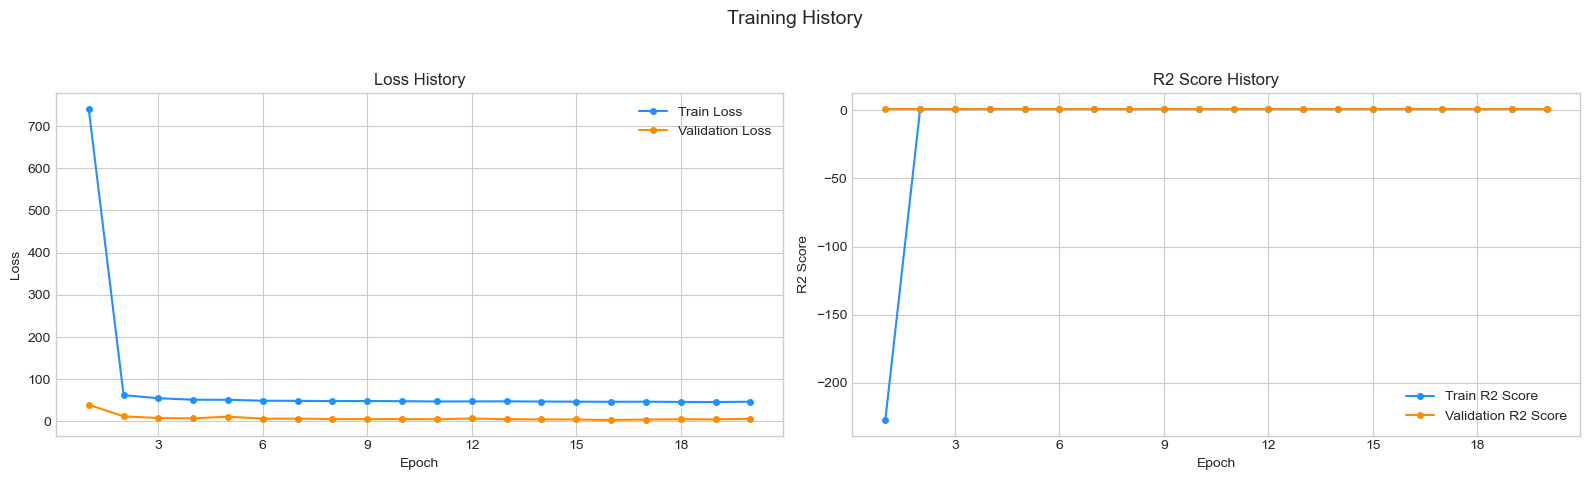

[Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Test результат:
Test Loss: 28.2575
Test R2 Score: 0.9454


(28.25745968783608, 0.9454298764333762)

In [34]:
# Начальные компоненты
initial_criterion = MSECriterion()
initial_optimizer = Adam(
    model_reg_small.getParameters(),
    learning_rate=1e-3,
    weight_decay=1e-5,
)
print(
    f"Начальные критерии ={initial_criterion.__class__.__name__}, Оптимайзер ={initial_optimizer.__class__.__name__}"
)

# Компоненты для ПЕРВОГО переключения (Критерий)
loss_switch_config = {
    "patience": 4,  # Ждем 4 эпохи без улучшения val_loss
    "threshold": 1e-3,  # Улучшение меньше порога не считается
    "mode": "min",  # Минимизируем val_loss
    "verbose": True,
}

# Создаем ЭКЗЕМПЛЯР следующего критерия
next_criterion = MAECriterion()
print(
    f"Loss Switch Config: Monitor val_loss, patience={loss_switch_config['patience']}, switch to {next_criterion.__class__.__name__}"
)

# Компоненты для ВТОРОГО переключения (Оптимизатор)
optimizer_switch_config = {
    "patience": 6,  # Ждем дольше (6 эпох) после смены критерия или если критерий не менялся
    "threshold": 5e-5,  # Более строгий порог для второго этапа
    "mode": "min",  # Продолжаем следить за val_loss
    "verbose": True,
}


next_opt_class = SGD
next_opt_params = {"learning_rate": 1e-3, "weight_decay": 0}

print(
    f"Optimizer Switch Config: Monitor val_loss, patience={optimizer_switch_config['patience']}, switch to {next_opt_class.__name__} with params {next_opt_params}"
)

# Early Stopping (увеличим patience, чтобы дать шанс переключениям)
early_stopping_reg_switch = EarlyStopping(
    patience=5,  # Должно быть больше, чем patience для переключений
    verbose=True,
    path="models/best_regression_model_small_switched.pkl",
)


reg_switch_history = train_validate_model(
    model=model_reg_small,
    initial_criterion=initial_criterion,
    initial_optimizer=initial_optimizer,
    X_train=X_reg_train,
    y_train=y_reg_train,
    X_val=X_reg_val,
    y_val=y_reg_val,
    epochs=20,
    batch_size=64,
    # --- Параметры для переключения Criterion ---
    loss_switch_trigger_config=loss_switch_config,
    next_criterion_instance=next_criterion,
    # --- Параметры для переключения Optimizer ---
    optimizer_switch_trigger_config=optimizer_switch_config,
    next_optimizer_class=next_opt_class,
    next_optimizer_params=next_opt_params,
    # --- Основные параметры ---
    scheduler=None,
    warmup_scheduler=None,
    early_stopping=early_stopping_reg_switch,
    metric_func=calculate_r2,
    metric_name="R2 Score",
    task_type="regression",
    metric_for_switch="val_loss",
)

test_model(
    model=model_reg_small,
    criterion=(
        next_criterion
        if "next_criterion" in locals()
        and early_stopping_reg_switch.best_score is not None
        and early_stopping_reg_switch.counter == 0
        else initial_criterion
    ),  # Используем критерий, который был активен при лучшей модели (или последний, если ES не сработал)
    X_test=X_reg_test,
    y_test=y_reg_test,
    batch_size=64,
    metric_func=calculate_r2,
    metric_name="R2 Score",
    task_type="regression",
)

Начальные критерии =MAECriterion, Оптимайзер =SGD
Loss Switch Config: Monitor val_loss, patience=4, switch to MSECriterion
Optimizer Switch Config: Monitor val_loss, patience=6, switch to Adam with params {'learning_rate': 0.001}
INFO: Loss switch monitoring enabled...
INFO: Optimizer switch monitoring enabled...

Starting training with Criterion: MAECriterion, Optimizer: SGD


Epoch 1/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 1/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/20 Summary: LR: 0.0019000000000000002 | Train Loss: 14.5234, Val Loss: 7.1949, Train R2 Score: -484.2393, Val R2 Score: -0.7290


Epoch 2/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 2/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/20 Summary: LR: 0.0028000000000000004 | Train Loss: 5.1948, Val Loss: 1.8615, Train R2 Score: 0.6205, Val R2 Score: 0.9534


Epoch 3/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 3/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/20 Summary: LR: 0.0037 | Train Loss: 4.3051, Val Loss: 1.6376, Train R2 Score: 0.8283, Val R2 Score: 0.9651


Epoch 4/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 4/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/20 Summary: LR: 0.004600000000000001 | Train Loss: 4.0949, Val Loss: 1.5373, Train R2 Score: 0.8473, Val R2 Score: 0.9717


Epoch 5/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 5/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5/20 Summary: LR: 0.0055000000000000005 | Train Loss: 3.9906, Val Loss: 1.7211, Train R2 Score: 0.8568, Val R2 Score: 0.9610
Stagnation Monitor: Нет улучшения для 1/4 epochs.
Stagnation Monitor: Нет улучшения для 1/6 epochs.


Epoch 6/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 6/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6/20 Summary: LR: 0.0064 | Train Loss: 3.9382, Val Loss: 1.4162, Train R2 Score: 0.8616, Val R2 Score: 0.9771


Epoch 7/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 7/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7/20 Summary: LR: 0.0073 | Train Loss: 3.8861, Val Loss: 1.5977, Train R2 Score: 0.8653, Val R2 Score: 0.9664
Stagnation Monitor: Нет улучшения для 1/4 epochs.
Stagnation Monitor: Нет улучшения для 1/6 epochs.


Epoch 8/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 8/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8/20 Summary: LR: 0.008200000000000002 | Train Loss: 3.8228, Val Loss: 1.6138, Train R2 Score: 0.8705, Val R2 Score: 0.9688
Stagnation Monitor: Нет улучшения для 2/4 epochs.
Stagnation Monitor: Нет улучшения для 2/6 epochs.


Epoch 9/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 9/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9/20 Summary: LR: 0.0091 | Train Loss: 3.7889, Val Loss: 1.4435, Train R2 Score: 0.8737, Val R2 Score: 0.9759
Stagnation Monitor: Нет улучшения для 3/4 epochs.
Stagnation Monitor: Нет улучшения для 3/6 epochs.


Epoch 10/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 10/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10/20 Summary: LR: 0.001 | Train Loss: 3.7077, Val Loss: 1.2195, Train R2 Score: 0.8786, Val R2 Score: 0.9825


Epoch 11/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 11/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11/20 Summary: LR: 0.001 | Train Loss: 3.6909, Val Loss: 1.1724, Train R2 Score: 0.8794, Val R2 Score: 0.9825


Epoch 12/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 12/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12/20 Summary: LR: 0.001 | Train Loss: 3.6503, Val Loss: 1.2864, Train R2 Score: 0.8819, Val R2 Score: 0.9788
Stagnation Monitor: Нет улучшения для 1/4 epochs.
Stagnation Monitor: Нет улучшения для 1/6 epochs.


Epoch 13/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 13/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13/20 Summary: LR: 0.001 | Train Loss: 3.6508, Val Loss: 1.4154, Train R2 Score: 0.8821, Val R2 Score: 0.9753
Stagnation Monitor: Нет улучшения для 2/4 epochs.
Stagnation Monitor: Нет улучшения для 2/6 epochs.


Epoch 14/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 14/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14/20 Summary: LR: 0.001 | Train Loss: 3.6785, Val Loss: 1.2599, Train R2 Score: 0.8814, Val R2 Score: 0.9783
Stagnation Monitor: Нет улучшения для 3/4 epochs.
Stagnation Monitor: Нет улучшения для 3/6 epochs.


Epoch 15/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 15/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15/20 Summary: LR: 0.001 | Train Loss: 3.6474, Val Loss: 1.3728, Train R2 Score: 0.8829, Val R2 Score: 0.9740
Stagnation Monitor: Нет улучшения для 4/4 epochs.
Stagnation Monitor: Стагнация обнаружена.
------------------------------
*** CRITERION SWITCH TRIGGERED ***
Switching from MAECriterion to MSECriterion
Stagnation Monitor: Reset.
------------------------------


Epoch 16/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 16/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16/20 Summary: LR: 0.001 | Train Loss: 71.7215, Val Loss: 12.5936, Train R2 Score: 0.8791, Val R2 Score: 0.9731
Stagnation Monitor: Нет улучшения для 1/6 epochs.


Epoch 17/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 17/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17/20 Summary: LR: 0.001 | Train Loss: 70.0939, Val Loss: 8.9037, Train R2 Score: 0.8813, Val R2 Score: 0.9806
Stagnation Monitor: Нет улучшения для 2/6 epochs.


Epoch 18/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 18/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18/20 Summary: LR: 0.001 | Train Loss: 69.6970, Val Loss: 10.0744, Train R2 Score: 0.8818, Val R2 Score: 0.9816
Stagnation Monitor: Нет улучшения для 3/6 epochs.


Epoch 19/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 19/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19/20 Summary: LR: 0.001 | Train Loss: 67.9712, Val Loss: 9.5156, Train R2 Score: 0.8848, Val R2 Score: 0.9809
Stagnation Monitor: Нет улучшения для 4/6 epochs.


Epoch 20/20 [Train]:   0%|          | 0/1063 [00:00<?, ?it/s]

Epoch 20/20 [Val] :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20/20 Summary: LR: 0.001 | Train Loss: 66.7643, Val Loss: 11.5098, Train R2 Score: 0.8861, Val R2 Score: 0.9776
Stagnation Monitor: Нет улучшения для 5/6 epochs.

Training finished.


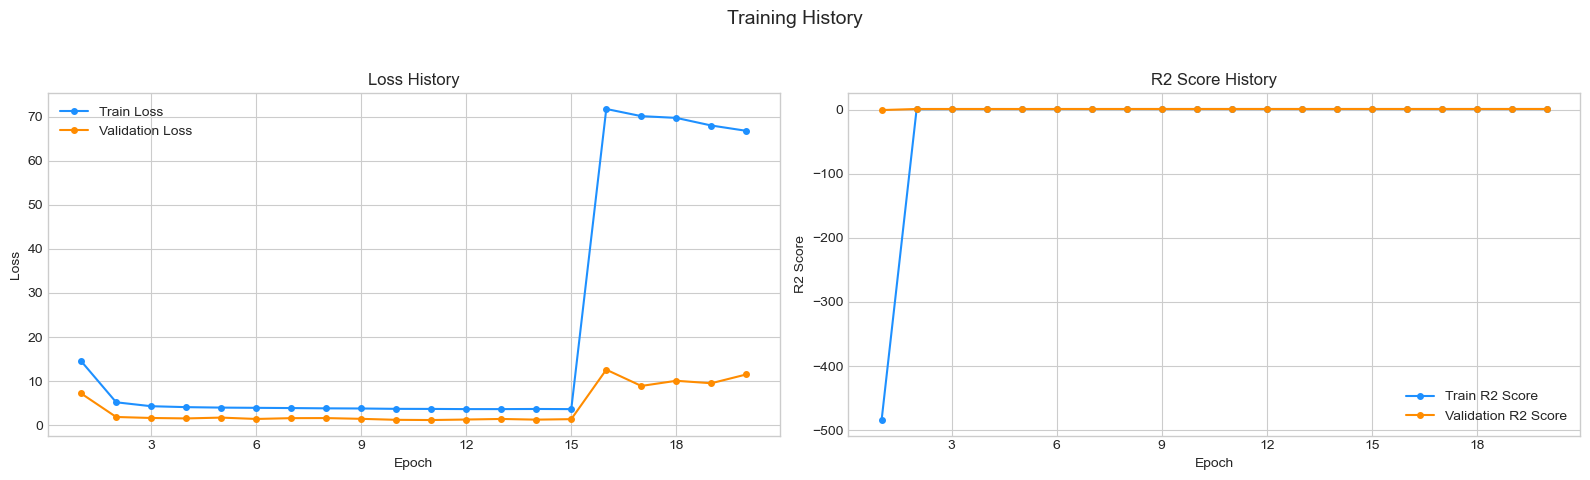

[Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Test результат:
Test Loss: 1.4438
Test R2 Score: 0.9773


(1.443753350155524, 0.9772622000447929)

In [35]:
# Начальные компоненты
initial_criterion = MAECriterion()
initial_optimizer = SGD(
    model_reg_medium.getParameters(),
)
print(
    f"Начальные критерии ={initial_criterion.__class__.__name__}, Оптимайзер ={initial_optimizer.__class__.__name__}"
)

loss_switch_config = {
    "patience": 4,
    "threshold": 1e-3,
    "mode": "min",
    "verbose": True,
}

next_criterion = MSECriterion()
print(
    f"Loss Switch Config: Monitor val_loss, patience={loss_switch_config['patience']}, switch to {next_criterion.__class__.__name__}"
)

optimizer_switch_config = {
    "patience": 6,
    "threshold": 5e-5,
    "mode": "min",
    "verbose": True,
}


next_opt_class = Adam
next_opt_params = {"learning_rate": 1e-3}

print(
    f"Optimizer Switch Config: Monitor val_loss, patience={optimizer_switch_config['patience']}, switch to {next_opt_class.__name__} with params {next_opt_params}"
)

warmup_scheduler = WarmupLR(
    optimizer=initial_optimizer, warmup_epochs=10, initial_lr=1e-3, target_lr=1e-2
)

reg_switch_history = train_validate_model(
    model=model_reg_medium,
    initial_criterion=initial_criterion,
    initial_optimizer=initial_optimizer,
    X_train=X_reg_train,
    y_train=y_reg_train,
    X_val=X_reg_val,
    y_val=y_reg_val,
    epochs=20,
    batch_size=64,
    # --- Параметры для переключения Criterion ---
    loss_switch_trigger_config=loss_switch_config,
    next_criterion_instance=next_criterion,
    # --- Параметры для переключения Optimizer ---
    optimizer_switch_trigger_config=optimizer_switch_config,
    next_optimizer_class=next_opt_class,
    next_optimizer_params=next_opt_params,
    # --- Основные параметры ---
    scheduler=None,
    warmup_scheduler=warmup_scheduler,
    early_stopping=None,
    metric_func=calculate_r2,
    metric_name="R2 Score",
    task_type="regression",
    metric_for_switch="val_loss",
)

test_model(
    model=model_reg_medium,
    criterion=(
        next_criterion
        if "next_criterion" in locals()
        and early_stopping_reg_switch.best_score is not None
        and early_stopping_reg_switch.counter == 0
        else initial_criterion
    ),  # Используем критерий, который был активен при лучшей модели (или последний, если ES не сработал)
    X_test=X_reg_test,
    y_test=y_reg_test,
    batch_size=64,
    metric_func=calculate_r2,
    metric_name="R2 Score",
    task_type="regression",
)

Начальные критерии =MAECriterion, Оптимайзер =SGD
Loss Switch Config: Monitor val_loss, patience=8, switch to MSECriterion
Optimizer Switch Config: Monitor val_loss, patience=4, switch to Adam with params {'learning_rate': 0.001}
INFO: Loss switch monitoring enabled...
INFO: Optimizer switch monitoring enabled...

Starting training with Criterion: MAECriterion, Optimizer: SGD


Epoch 1/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 1/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/20 Summary: LR: 0.001 | Train Loss: 19.5342, Val Loss: 17.6073, Train R2 Score: -1384.7582, Val R2 Score: -55.4016
  Validation loss decreased (inf --> 17.607332). Saving model ...


Epoch 2/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 2/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/20 Summary: LR: 0.001 | Train Loss: 13.2223, Val Loss: 5.7854, Train R2 Score: -16.9743, Val R2 Score: 0.0359
  Validation loss decreased (17.607332 --> 5.785410). Saving model ...


Epoch 3/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 3/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/20 Summary: LR: 0.001 | Train Loss: 5.6951, Val Loss: 3.1855, Train R2 Score: 0.5962, Val R2 Score: 0.8909
  Validation loss decreased (5.785410 --> 3.185493). Saving model ...


Epoch 4/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 4/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/20 Summary: LR: 0.001 | Train Loss: 5.1740, Val Loss: 2.6504, Train R2 Score: 0.7399, Val R2 Score: 0.9204
  Validation loss decreased (3.185493 --> 2.650414). Saving model ...


Epoch 5/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 5/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/20 Summary: LR: 0.001 | Train Loss: 5.0093, Val Loss: 2.7353, Train R2 Score: 0.7631, Val R2 Score: 0.9233
Stagnation Monitor: Нет улучшения для 1/8 epochs.
Stagnation Monitor: Нет улучшения для 1/4 epochs.
  EarlyStopping counter: 1 out of 10


Epoch 6/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 6/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/20 Summary: LR: 0.001 | Train Loss: 4.9115, Val Loss: 2.6019, Train R2 Score: 0.7750, Val R2 Score: 0.9299
  Validation loss decreased (2.650414 --> 2.601935). Saving model ...


Epoch 7/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 7/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/20 Summary: LR: 0.001 | Train Loss: 4.8541, Val Loss: 2.4899, Train R2 Score: 0.7827, Val R2 Score: 0.9328
  Validation loss decreased (2.601935 --> 2.489910). Saving model ...


Epoch 8/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 8/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/20 Summary: LR: 0.001 | Train Loss: 4.7942, Val Loss: 2.4656, Train R2 Score: 0.7887, Val R2 Score: 0.9345
  Validation loss decreased (2.489910 --> 2.465567). Saving model ...


Epoch 9/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 9/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/20 Summary: LR: 0.001 | Train Loss: 4.7716, Val Loss: 2.4380, Train R2 Score: 0.7919, Val R2 Score: 0.9350
  Validation loss decreased (2.465567 --> 2.438038). Saving model ...


Epoch 10/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 10/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/20 Summary: LR: 0.0001 | Train Loss: 4.7350, Val Loss: 2.6389, Train R2 Score: 0.7957, Val R2 Score: 0.9322
Stagnation Monitor: Нет улучшения для 1/8 epochs.
Stagnation Monitor: Нет улучшения для 1/4 epochs.
  EarlyStopping counter: 1 out of 10


Epoch 11/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 11/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/20 Summary: LR: 0.0001 | Train Loss: 4.7356, Val Loss: 2.5379, Train R2 Score: 0.7947, Val R2 Score: 0.9324
Stagnation Monitor: Нет улучшения для 2/8 epochs.
Stagnation Monitor: Нет улучшения для 2/4 epochs.
  EarlyStopping counter: 2 out of 10


Epoch 12/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 12/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/20 Summary: LR: 0.0001 | Train Loss: 4.7182, Val Loss: 2.5020, Train R2 Score: 0.7965, Val R2 Score: 0.9330
Stagnation Monitor: Нет улучшения для 3/8 epochs.
Stagnation Monitor: Нет улучшения для 3/4 epochs.
  EarlyStopping counter: 3 out of 10


Epoch 13/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 13/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/20 Summary: LR: 0.0001 | Train Loss: 4.7145, Val Loss: 2.3640, Train R2 Score: 0.7972, Val R2 Score: 0.9393
  Validation loss decreased (2.438038 --> 2.363965). Saving model ...


Epoch 14/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 14/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/20 Summary: LR: 0.0001 | Train Loss: 4.7052, Val Loss: 2.3564, Train R2 Score: 0.7980, Val R2 Score: 0.9395
  Validation loss decreased (2.363965 --> 2.356436). Saving model ...


Epoch 15/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 15/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/20 Summary: LR: 0.0001 | Train Loss: 4.6848, Val Loss: 2.4709, Train R2 Score: 0.8000, Val R2 Score: 0.9357
Stagnation Monitor: Нет улучшения для 1/8 epochs.
Stagnation Monitor: Нет улучшения для 1/4 epochs.
  EarlyStopping counter: 1 out of 10


Epoch 16/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 16/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 16/20 Summary: LR: 0.0001 | Train Loss: 4.6889, Val Loss: 2.3383, Train R2 Score: 0.7992, Val R2 Score: 0.9388
  Validation loss decreased (2.356436 --> 2.338304). Saving model ...


Epoch 17/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 17/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 17/20 Summary: LR: 0.0001 | Train Loss: 4.6836, Val Loss: 2.4556, Train R2 Score: 0.8000, Val R2 Score: 0.9351
Stagnation Monitor: Нет улучшения для 1/8 epochs.
Stagnation Monitor: Нет улучшения для 1/4 epochs.
  EarlyStopping counter: 1 out of 10


Epoch 18/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 18/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 18/20 Summary: LR: 0.0001 | Train Loss: 4.7159, Val Loss: 2.4031, Train R2 Score: 0.7984, Val R2 Score: 0.9389
Stagnation Monitor: Нет улучшения для 2/8 epochs.
Stagnation Monitor: Нет улучшения для 2/4 epochs.
  EarlyStopping counter: 2 out of 10


Epoch 19/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 19/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 19/20 Summary: LR: 0.0001 | Train Loss: 4.6866, Val Loss: 2.3822, Train R2 Score: 0.8000, Val R2 Score: 0.9386
Stagnation Monitor: Нет улучшения для 3/8 epochs.
Stagnation Monitor: Нет улучшения для 3/4 epochs.
  EarlyStopping counter: 3 out of 10


Epoch 20/20 [Train]:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch 20/20 [Val] :   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 20/20 Summary: LR: 1e-05 | Train Loss: 4.7030, Val Loss: 2.3770, Train R2 Score: 0.7991, Val R2 Score: 0.9390
Stagnation Monitor: Нет улучшения для 4/8 epochs.
Stagnation Monitor: Нет улучшения для 4/4 epochs.
Stagnation Monitor: Стагнация обнаружена.
  Optimizer stagnation detected, but waiting for potential loss switch.
  EarlyStopping counter: 4 out of 10

Training finished.
Loading best model based on early stopping criterion...
Loading best model from models/best_regression_model_large_switched.pkl with val_loss: 2.338304


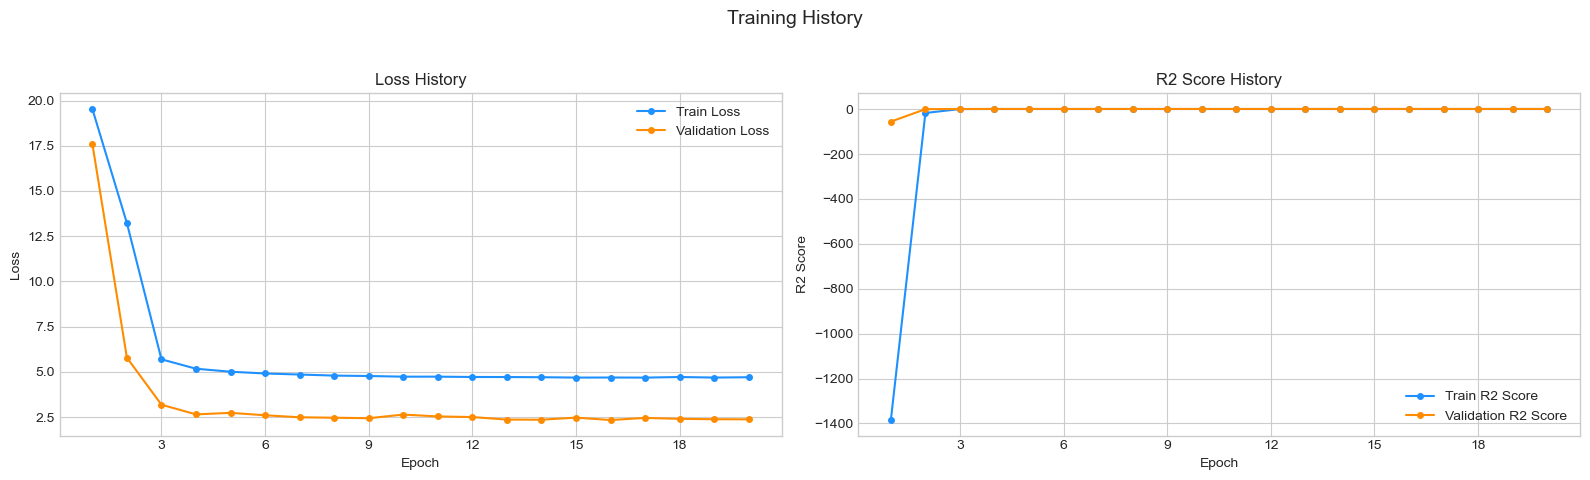

[Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Test результат:
Test Loss: 2.3632
Test R2 Score: 0.9389


(2.3631608051379476, 0.9389259734654887)

In [36]:
# Начальные компоненты
initial_criterion = MAECriterion()
initial_optimizer = SGD(
    model_reg_large.getParameters(),
)
print(
    f"Начальные критерии ={initial_criterion.__class__.__name__}, Оптимайзер ={initial_optimizer.__class__.__name__}"
)

loss_switch_config = {
    "patience": 8,
    "threshold": 1e-3,
    "mode": "min",
    "verbose": True,
}

next_criterion = MSECriterion()
print(
    f"Loss Switch Config: Monitor val_loss, patience={loss_switch_config['patience']}, switch to {next_criterion.__class__.__name__}"
)

optimizer_switch_config = {
    "patience": 4,
    "threshold": 5e-5,
    "mode": "min",
    "verbose": True,
}


next_opt_class = Adam
next_opt_params = {"learning_rate": 1e-3}

print(
    f"Optimizer Switch Config: Monitor val_loss, patience={optimizer_switch_config['patience']}, switch to {next_opt_class.__name__} with params {next_opt_params}"
)

# Early Stopping (увеличим patience, чтобы дать шанс переключениям)
early_stopping_reg_switch = EarlyStopping(
    patience=10,
    verbose=True,
    path="models/best_regression_model_large_switched.pkl",
)

lr_scheduler = StepLR(initial_optimizer, step_size=10, gamma=0.1)

reg_switch_history = train_validate_model(
    model=model_reg_large,
    initial_criterion=initial_criterion,
    initial_optimizer=initial_optimizer,
    X_train=X_reg_train,
    y_train=y_reg_train,
    X_val=X_reg_val,
    y_val=y_reg_val,
    epochs=20,
    batch_size=32,
    # --- Параметры для переключения Criterion ---
    loss_switch_trigger_config=loss_switch_config,
    next_criterion_instance=next_criterion,
    # --- Параметры для переключения Optimizer ---
    optimizer_switch_trigger_config=optimizer_switch_config,
    next_optimizer_class=next_opt_class,
    next_optimizer_params=next_opt_params,
    # --- Основные параметры ---
    scheduler=lr_scheduler,
    warmup_scheduler=None,
    early_stopping=early_stopping_reg_switch,
    metric_func=calculate_r2,
    metric_name="R2 Score",
    task_type="regression",
    metric_for_switch="val_loss",
)

test_model(
    model=model_reg_large,
    criterion=(
        next_criterion
        if "next_criterion" in locals()
        and early_stopping_reg_switch.best_score is not None
        and early_stopping_reg_switch.counter == 0
        else initial_criterion
    ),  # Используем критерий, который был активен при лучшей модели (или последний, если ES не сработал)
    X_test=X_reg_test,
    y_test=y_reg_test,
    batch_size=64,
    metric_func=calculate_r2,
    metric_name="R2 Score",
    task_type="regression",
)

# Обучение CNN модел на датасете MNIST 

In [ ]:
mnist_train_val = MNIST(root="./data", train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root="./data", train=False, download=True, transform=ToTensor())

X_mnist = (
    mnist_train_val.data.numpy().astype(np.float32) / 255.0
)  # Нормализация в [0, 1]
y_mnist = mnist_train_val.targets.numpy()
X_test_mnist = mnist_test.data.numpy().astype(np.float32) / 255.0
y_test_mnist = mnist_test.targets.numpy()

# Добавляем ось каналов
X_mnist = X_mnist[:, None, :, :]  # (60000, 1, 28, 28)
X_test_mnist = X_test_mnist[:, None, :, :]  # (10000, 1, 28, 28)


X_train_mnist, X_val_mnist, y_train_mnist, y_val_mnist = train_test_split(
    X_mnist,
    y_mnist,
    test_size=0.25,
    random_state=42,
    stratify=y_mnist,
)


Starting training with Criterion: CrossEntropyCriterion, Optimizer: Adam


Epoch 1/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 Summary: LR: 0.005 | Train Loss: 0.1523, Val Loss: 0.0559, Train f1-score('weighted'): 0.9523, Val f1-score('weighted'): 0.9826
  Validation loss decreased (inf --> 0.055915). Saving model ...


Epoch 2/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 Summary: LR: 0.005 | Train Loss: 0.0751, Val Loss: 0.0498, Train f1-score('weighted'): 0.9758, Val f1-score('weighted'): 0.9840
  Validation loss decreased (0.055915 --> 0.049751). Saving model ...


Epoch 3/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 3/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 Summary: LR: 0.005 | Train Loss: 0.0592, Val Loss: 0.0408, Train f1-score('weighted'): 0.9804, Val f1-score('weighted'): 0.9877
  Validation loss decreased (0.049751 --> 0.040835). Saving model ...


Epoch 4/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 4/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 Summary: LR: 0.005 | Train Loss: 0.0543, Val Loss: 0.0407, Train f1-score('weighted'): 0.9821, Val f1-score('weighted'): 0.9880
  Validation loss decreased (0.040835 --> 0.040726). Saving model ...


Epoch 5/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 5/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 Summary: LR: 0.005 | Train Loss: 0.0504, Val Loss: 0.0340, Train f1-score('weighted'): 0.9837, Val f1-score('weighted'): 0.9904
  Validation loss decreased (0.040726 --> 0.033980). Saving model ...

Training finished.
Loading best model based on early stopping criterion...
Loading best model from models/best_cnn_model.pkl with val_loss: 0.033980


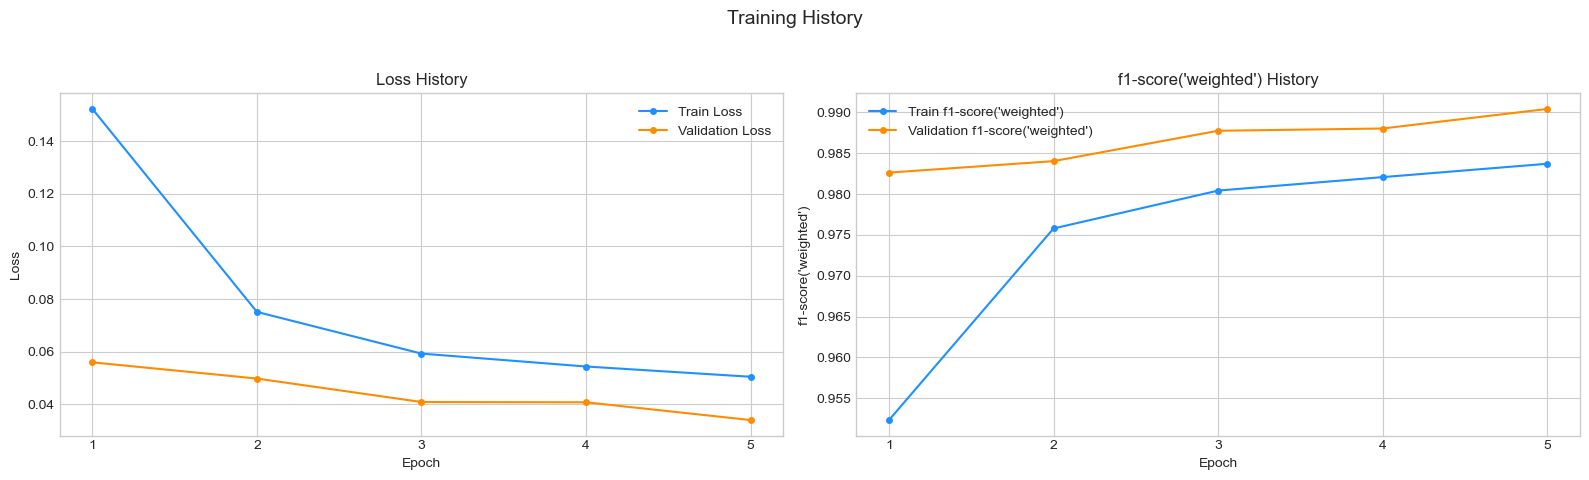

[Test]:   0%|          | 0/313 [00:00<?, ?it/s]

Test результат:
Test Loss: 0.0343
Test f1-score('weighted'): 0.9895


(0.03426074209941709, 0.9894706344635755)

In [39]:
model_cnn = Sequential()  # Вход: (N, 1, 28, 28)

model_cnn.add(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1))
model_cnn.add(ReLU())
model_cnn.add(MaxPool2d(kernel_size=2, stride=2))  # Выход: (N, 32, 14, 14)

model_cnn.add(Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model_cnn.add(ReLU())
model_cnn.add(MaxPool2d(kernel_size=2, stride=2))  # Выход: (N, 64, 7, 7)
model_cnn.add(Dropout(p=0.1))

model_cnn.add(
    Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
)  # Выход: (N, 128, 7, 7)
model_cnn.add(ReLU())
model_cnn.add(Dropout(p=0.2))

model_cnn.add(AvgPool2d(kernel_size=7))  # Выход: (N, 128, 1, 1)

model_cnn.add(Flatten())  # Выход: (N, 128)

model_cnn.add(BatchNormalization())

model_cnn.add(Linear(n_in=128, n_out=10))

criterion_cnn = CrossEntropyCriterion()
optimizer_cnn = Adam(model_cnn.getParameters(), learning_rate=0.005)

early_stopping_cnn = EarlyStopping(
    patience=5, verbose=True, path="models/best_cnn_model.pkl"
)

cnn_history = train_validate_model(
    model_cnn,
    criterion_cnn,
    optimizer_cnn,
    scheduler=None,
    warmup_scheduler=None,
    early_stopping=early_stopping_cnn,
    X_train=X_train_mnist,
    y_train=y_train_mnist,
    X_val=X_val_mnist,
    y_val=y_val_mnist,
    epochs=5,
    batch_size=32,
    metric_func=calculate_f1,
    metric_name="f1-score('weighted')",
    task_type="classification",
)

test_model(
    model_cnn,
    criterion_cnn,
    X_test_mnist,
    y_test_mnist,
    batch_size=32,
    metric_func=calculate_f1,
    metric_name="f1-score('weighted')",
    task_type="classification",
)

In [40]:
class Upsample(
    Module
):  # Увеличить размер карты признаков простым копированием пикселей.

    def __init__(self, scale_factor=2):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.input_shape = None

    def updateOutput(self, input):
        self.input_shape = input.shape
        N, C, H, W = input.shape
        H_out = H * self.scale_factor
        W_out = W * self.scale_factor
        # Простое повторение строк и столбцов
        self.output = input.repeat(self.scale_factor, axis=2).repeat(
            self.scale_factor, axis=3
        )
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Градиент нужно "сложить" из соответствующих пикселей gradOutput
        N, C, H_out, W_out = gradOutput.shape
        H_in = H_out // self.scale_factor
        W_in = W_out // self.scale_factor
        # Решейпим gradOutput и суммируем по блокам scale_factor x scale_factor
        # (N, C, H_in, sf, W_in, sf) -> sum over sf axes (3, 5)
        gradOutput_reshaped = gradOutput.reshape(
            N, C, H_in, self.scale_factor, W_in, self.scale_factor
        )
        self.gradInput = gradOutput_reshaped.sum(axis=(3, 5))
        return self.gradInput

INFO: Optimizer switch monitoring enabled...

Starting training with Criterion: MSECriterion, Optimizer: SGD


Epoch 1/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 Summary: LR: 0.001 | Train Loss: 5.5020, Val Loss: 3.2929
  Validation loss decreased (inf --> 3.292867). Saving model ...


Epoch 2/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 Summary: LR: 0.001 | Train Loss: 2.9989, Val Loss: 2.6748
  Validation loss decreased (3.292867 --> 2.674784). Saving model ...


Epoch 3/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 3/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 Summary: LR: 0.001 | Train Loss: 2.5557, Val Loss: 2.3749
  Validation loss decreased (2.674784 --> 2.374879). Saving model ...


Epoch 4/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 4/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 Summary: LR: 0.001 | Train Loss: 2.3168, Val Loss: 2.1908
  Validation loss decreased (2.374879 --> 2.190795). Saving model ...


Epoch 5/5 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 5/5 [Val] :   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 Summary: LR: 0.001 | Train Loss: 2.1611, Val Loss: 2.1187
  Validation loss decreased (2.190795 --> 2.118731). Saving model ...

Training finished.
Loading best model based on early stopping criterion...
Loading best model from models/best_autoencoder_model.pkl with val_loss: 2.118731


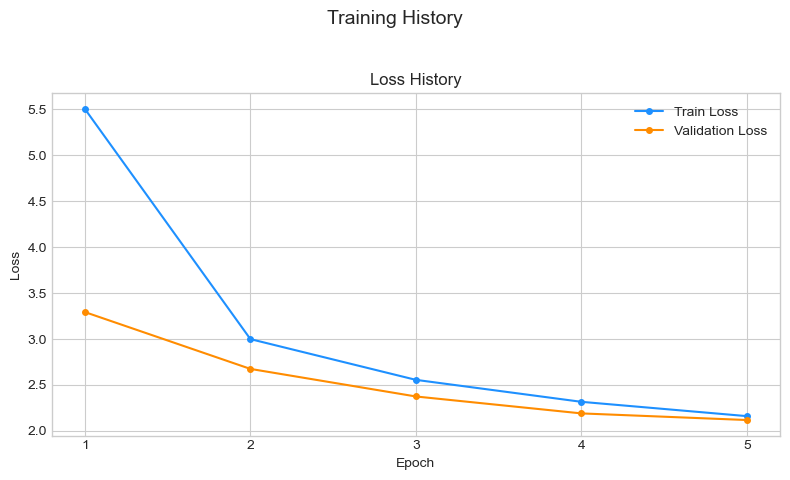

[Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Test результат:
Test Loss: 2.0454


In [42]:
X_ae_train, X_ae_val = X_train_mnist, X_val_mnist
X_ae_test = X_test_mnist

encoder = Sequential()
# Input: (N, 1, 28, 28)
encoder.add(Conv2d(1, 16, 3, stride=2, padding=1))  # (N, 16, 14, 14)
encoder.add(ReLU())
encoder.add(Conv2d(16, 32, 3, stride=2, padding=1))  # (N, 32, 7, 7) - Latent

decoder = Sequential()
# Input: (N, 32, 7, 7)
decoder.add(Upsample(scale_factor=2))  # (N, 32, 14, 14)
decoder.add(Conv2d(32, 16, 3, padding=1))  # (N, 16, 14, 14)
decoder.add(ReLU())
decoder.add(Upsample(scale_factor=2))  # (N, 16, 28, 28)
decoder.add(Conv2d(16, 1, 3, padding=1))  # (N, 1, 28, 28)
decoder.add(Sigmoid())  # Выход в [0, 1], как и входные данные MNIST

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

criterion_ae = MSECriterion()

optimizer_ae = SGD(learning_rate=0.001, model_parameters=autoencoder.getParameters())
early_stopping_ae = EarlyStopping(
    patience=4, verbose=True, path="models/best_autoencoder_model.pkl"
)

next_opt_class = Adam
next_opt_params = {"learning_rate": 0.0015}

optimizer_switch_config = {
    "patience": 2,
    "threshold": 5e-5,
    "mode": "min",
    "verbose": True,
}

ae_history = train_validate_model(
    autoencoder,
    initial_criterion=criterion_ae,
    initial_optimizer=optimizer_ae,
    next_optimizer_class=next_opt_class,
    next_optimizer_params=next_opt_params,
    scheduler=None,
    warmup_scheduler=None,
    early_stopping=early_stopping_ae,
    X_train=X_ae_train,
    y_train=X_ae_train,
    X_val=X_ae_val,
    y_val=X_ae_val,
    epochs=5,
    batch_size=32,
    metric_func=None,
    task_type="regression",
    optimizer_switch_trigger_config=optimizer_switch_config,
)


test_loss_ae, _ = test_model(
    autoencoder,
    criterion_ae,
    X_ae_test,
    X_ae_test,
    batch_size=64,
    task_type="regression",
)

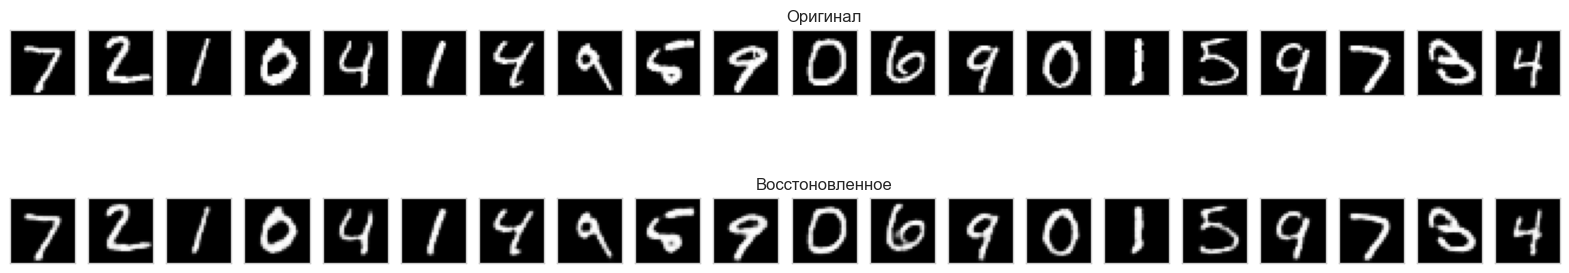

In [43]:
n_images_to_show = 20
autoencoder.evaluate()
test_output = autoencoder.forward(X_ae_test[:n_images_to_show])

plt.figure(figsize=(20, 4))
for i in range(n_images_to_show):
    ax = plt.subplot(2, n_images_to_show, i + 1)
    plt.imshow(X_ae_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_images_to_show // 2:
        ax.set_title("Оригинал")

    ax = plt.subplot(2, n_images_to_show, i + 1 + n_images_to_show)
    plt.imshow(test_output[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_images_to_show // 2:
        ax.set_title("Восстоновленное")
plt.show()